# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#FC8019; overflow:hidden"><b>Import libraries and load data</b></div>

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings 
import re 
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")


df=pd.read_csv("/kaggle/input/food-order-cost-and-profit-analysis/food_orders_new_delhi (1).csv")
print(df.info())
print(df.isnull().sum())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB
None
Order ID                    0
Customer ID                 0
Restaurant ID               0
Order Date and Time 

# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#FC8019; overflow:hidden"><b>Data  cleaning and Preprocessing</b></div>

In [2]:
df['Order Date and Time'] = pd.to_datetime(df['Order Date and Time'])
df['Delivery Date and Time'] = pd.to_datetime(df['Delivery Date and Time'])
df['Delivery Duration'] = (df['Delivery Date and Time'] - df['Order Date and Time']).dt.total_seconds() / 60
print(df[['Order Date and Time', 'Delivery Date and Time', 'Delivery Duration']].head())

  Order Date and Time Delivery Date and Time  Delivery Duration
0 2024-02-01 01:11:52    2024-02-01 02:39:52               88.0
1 2024-02-02 22:11:04    2024-02-02 22:46:04               35.0
2 2024-01-31 05:54:35    2024-01-31 06:52:35               58.0
3 2024-01-16 22:52:49    2024-01-16 23:38:49               46.0
4 2024-01-29 01:19:30    2024-01-29 02:48:30               89.0


In [3]:
df['Discounts and Offers'].fillna('No Discount', inplace=True)
print(df.isnull().sum())

Order ID                  0
Customer ID               0
Restaurant ID             0
Order Date and Time       0
Delivery Date and Time    0
Order Value               0
Delivery Fee              0
Payment Method            0
Discounts and Offers      0
Commission Fee            0
Payment Processing Fee    0
Refunds/Chargebacks       0
Delivery Duration         0
dtype: int64


In [4]:
print(df['Discounts and Offers'])

0         5% on App
1               10%
2      15% New User
3       No Discount
4      50 off Promo
           ...     
995       5% on App
996     No Discount
997     No Discount
998    15% New User
999    15% New User
Name: Discounts and Offers, Length: 1000, dtype: object


In [5]:
def parse_discount(discount):
    if discount.lower() == 'no discount':
        return 0
    elif '%' in discount:
        match = re.search(r'(\d+)%', discount)
        if match:
            return float(match.group(1))
    elif 'off' in discount.lower():
        match = re.search(r'(\d+)', discount)
        if match:
            return float(match.group(1))
    return 0  

def discount_type(discount):
    if discount.lower() == 'no discount':
        return 'No Discount'
    elif '%' in discount:
        return 'Percentage'
    elif 'off' in discount.lower():
        return 'Fixed'
    else:
        return 'Other'

In [6]:
df['Discount Value'] = df['Discounts and Offers'].apply(parse_discount)
df['Discount Type'] = df['Discounts and Offers'].apply(discount_type)

In [7]:
print(df[['Discounts and Offers', 'Discount Value', 'Discount Type']].head(15))

   Discounts and Offers  Discount Value Discount Type
0             5% on App             5.0    Percentage
1                   10%            10.0    Percentage
2          15% New User            15.0    Percentage
3           No Discount             0.0   No Discount
4          50 off Promo            50.0         Fixed
5                   10%            10.0    Percentage
6             5% on App             5.0    Percentage
7                   10%            10.0    Percentage
8             5% on App             5.0    Percentage
9                   10%            10.0    Percentage
10            5% on App             5.0    Percentage
11         15% New User            15.0    Percentage
12          No Discount             0.0   No Discount
13         15% New User            15.0    Percentage
14          No Discount             0.0   No Discount


In [8]:
def calculate_discount_amount(row):
    if row['Discount Type'] == 'Percentage':
        return row['Order Value'] * (row['Discount Value'] / 100)
    elif row['Discount Type'] == 'Fixed':
        return row['Discount Value']
    else:
        return 0

df['Discount Amount'] = df.apply(calculate_discount_amount, axis=1)

In [9]:
print(df[['Order Value', 'Discounts and Offers', 'Discount Value', 'Discount Type', 'Discount Amount']].head(50))

    Order Value Discounts and Offers  Discount Value Discount Type  \
0          1914            5% on App             5.0    Percentage   
1           986                  10%            10.0    Percentage   
2           937         15% New User            15.0    Percentage   
3          1463          No Discount             0.0   No Discount   
4          1992         50 off Promo            50.0         Fixed   
5           439                  10%            10.0    Percentage   
6           303            5% on App             5.0    Percentage   
7           260                  10%            10.0    Percentage   
8          1663            5% on App             5.0    Percentage   
9           491                  10%            10.0    Percentage   
10          868            5% on App             5.0    Percentage   
11         1800         15% New User            15.0    Percentage   
12          674          No Discount             0.0   No Discount   
13          633     

In [10]:
# profit
df['Profit'] = df['Order Value'] - df['Delivery Fee'] - df['Commission Fee'] - \
              df['Payment Processing Fee'] - df['Refunds/Chargebacks'] - df['Discount Amount']
print(df[['Order Value', 'Delivery Fee', 'Commission Fee', 
          'Payment Processing Fee', 'Refunds/Chargebacks', 
          'Discount Amount', 'Profit']].head(15))

    Order Value  Delivery Fee  Commission Fee  Payment Processing Fee  \
0          1914             0             150                      47   
1           986            40             198                      23   
2           937            30             195                      45   
3          1463            50             146                      27   
4          1992            30             130                      50   
5           439            20              92                      27   
6           303            30             144                      12   
7           260             0              55                      19   
8          1663            40             116                      48   
9           491            40             189                      10   
10          868             0             149                      36   
11         1800            20              61                      36   
12          674             0             115      

# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#FC8019; overflow:hidden"><b>EDA</b></div>

In [11]:
print(df.describe())

          Order ID            Order Date and Time  \
count  1000.000000                           1000   
mean    500.500000     2024-01-20 11:03:07.648000   
min       1.000000            2024-01-01 02:12:47   
25%     250.750000  2024-01-11 18:45:27.249999872   
50%     500.500000            2024-01-20 11:38:43   
75%     750.250000  2024-01-30 03:47:34.249999872   
max    1000.000000            2024-02-07 23:56:12   
std     288.819436                            NaN   

              Delivery Date and Time  Order Value  Delivery Fee  \
count                           1000  1000.000000   1000.000000   
mean   2024-01-20 12:16:42.148000256  1053.969000     28.620000   
min              2024-01-01 03:59:47   104.000000      0.000000   
25%    2024-01-11 19:54:57.249999872   597.750000     20.000000   
50%              2024-01-20 13:02:23  1038.500000     30.000000   
75%    2024-01-30 05:09:34.249999872  1494.000000     40.000000   
max              2024-02-08 01:45:12  1995.000000    

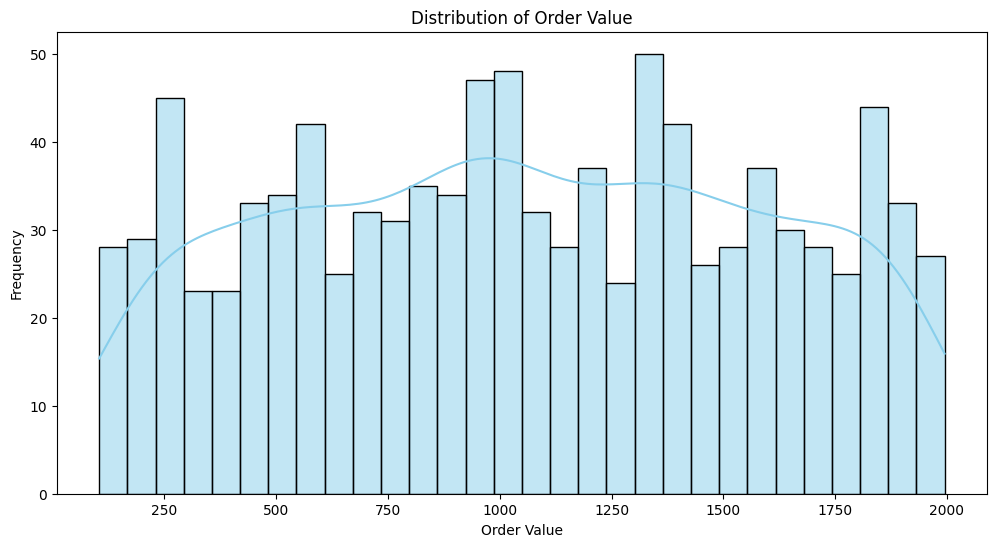

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Order Value'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Order Value')
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.show()


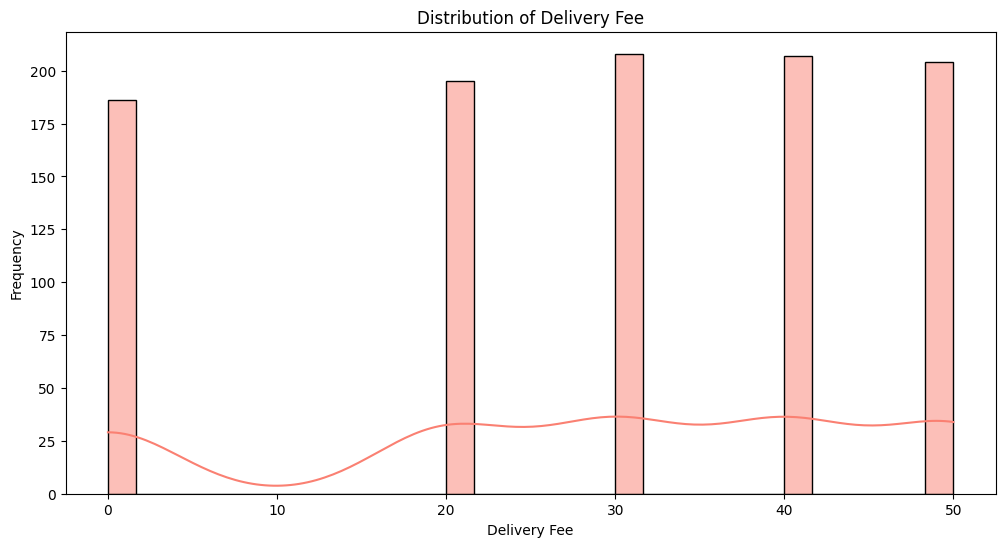

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Delivery Fee'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Delivery Fee')
plt.xlabel('Delivery Fee')
plt.ylabel('Frequency')
plt.show()


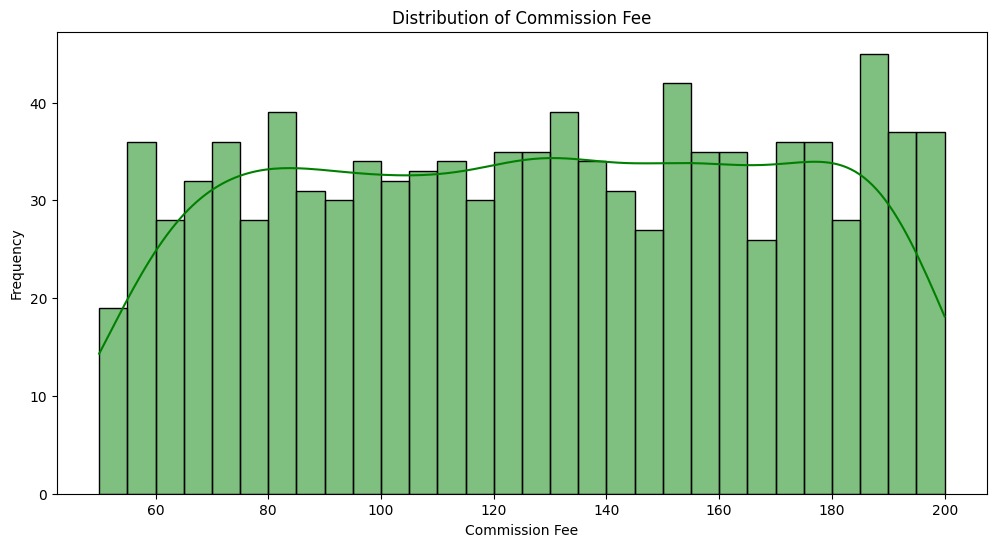

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Commission Fee'], bins=30, kde=True, color='green')
plt.title('Distribution of Commission Fee')
plt.xlabel('Commission Fee')
plt.ylabel('Frequency')
plt.show()


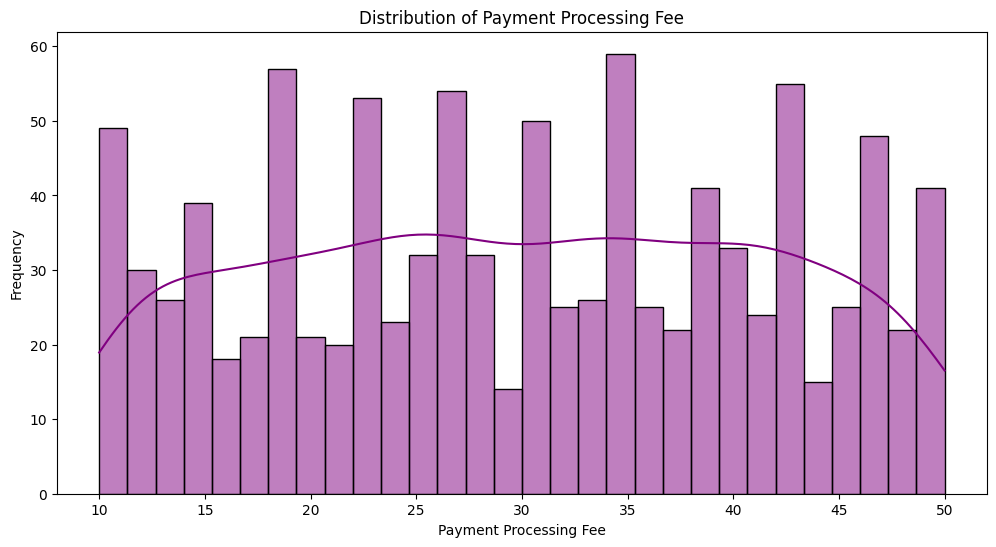

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Payment Processing Fee'], bins=30, kde=True, color='purple')
plt.title('Distribution of Payment Processing Fee')
plt.xlabel('Payment Processing Fee')
plt.ylabel('Frequency')
plt.show()


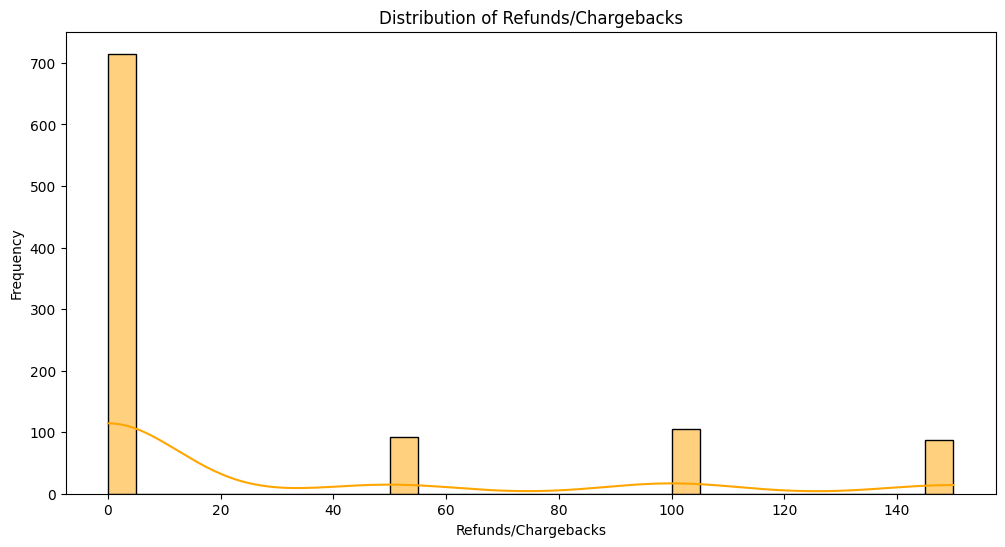

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Refunds/Chargebacks'], bins=30, kde=True, color='orange')
plt.title('Distribution of Refunds/Chargebacks')
plt.xlabel('Refunds/Chargebacks')
plt.ylabel('Frequency')
plt.show()


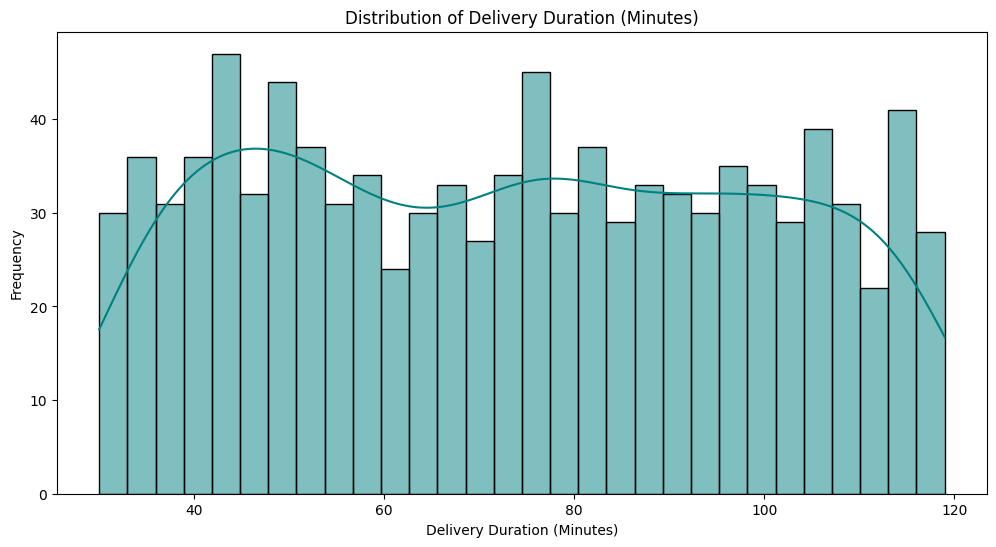

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Delivery Duration'], bins=30, kde=True, color='teal')
plt.title('Distribution of Delivery Duration (Minutes)')
plt.xlabel('Delivery Duration (Minutes)')
plt.ylabel('Frequency')
plt.show()


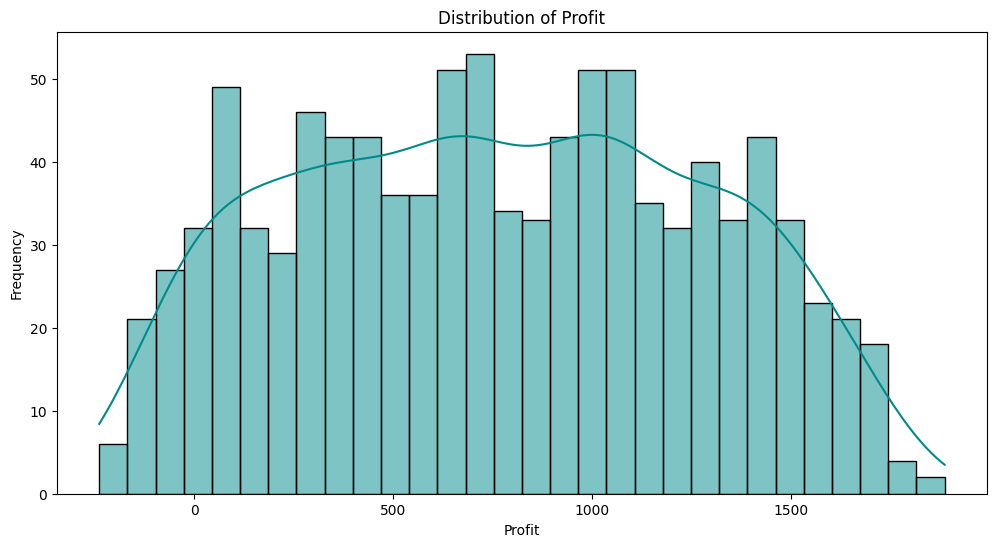

In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Profit'], bins=30, kde=True, color='darkcyan')
plt.title('Distribution of Profit')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.show()


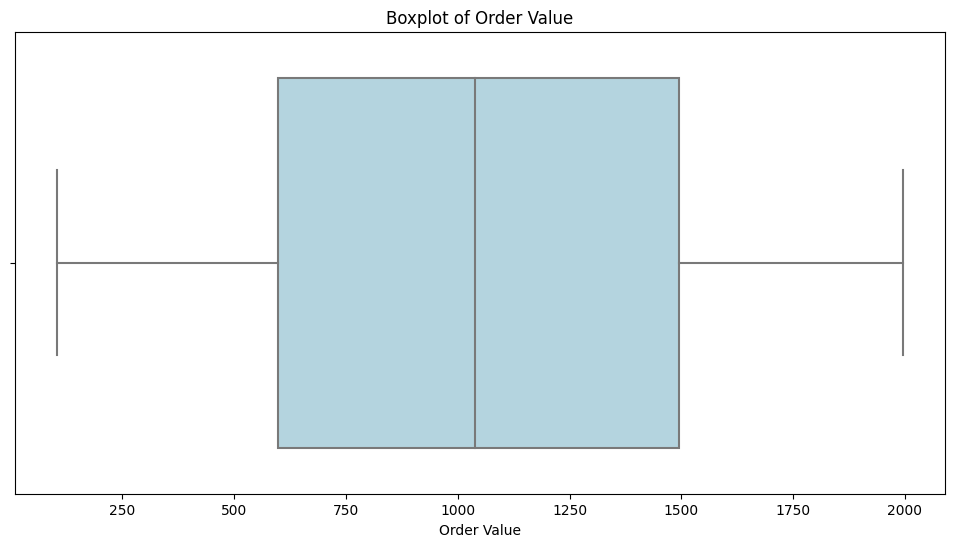

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Order Value', data=df, color='lightblue')
plt.title('Boxplot of Order Value')
plt.xlabel('Order Value')
plt.show()


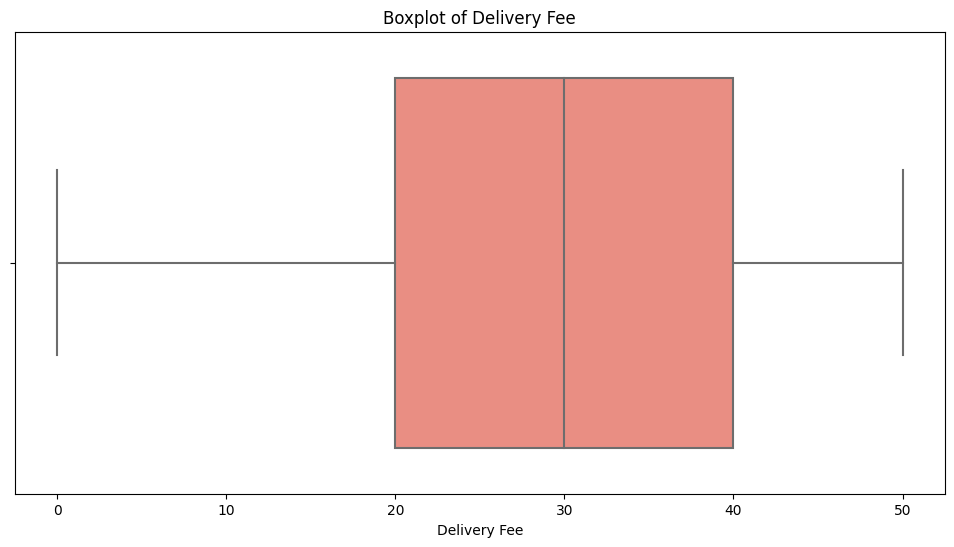

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Delivery Fee', data=df, color='salmon')
plt.title('Boxplot of Delivery Fee')
plt.xlabel('Delivery Fee')
plt.show()


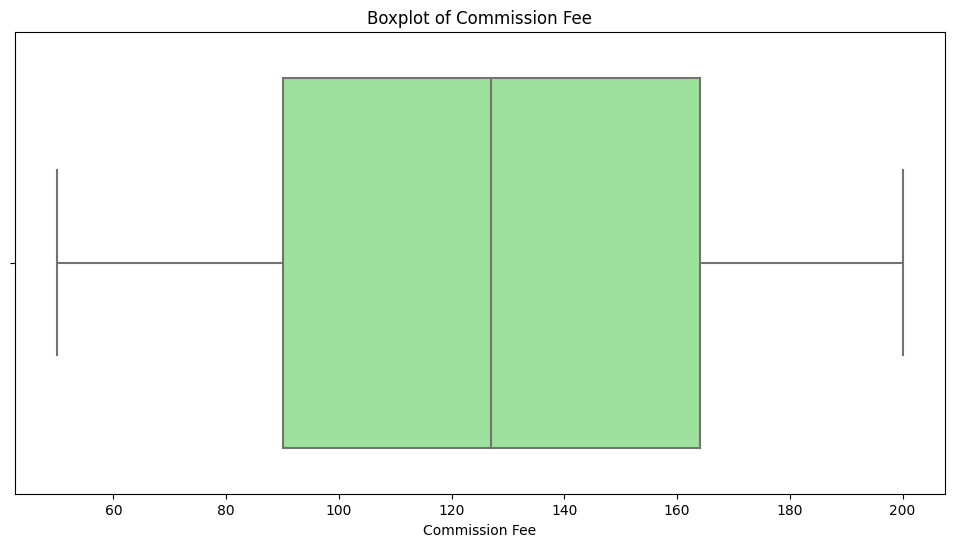

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Commission Fee', data=df, color='lightgreen')
plt.title('Boxplot of Commission Fee')
plt.xlabel('Commission Fee')
plt.show()


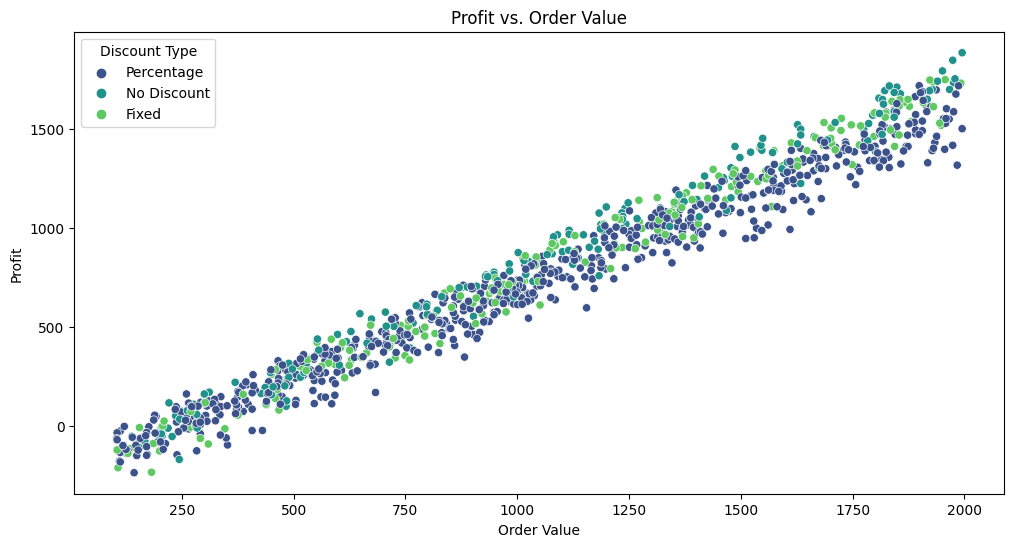

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Order Value', y='Profit', data=df, hue='Discount Type', palette='viridis')
plt.title('Profit vs. Order Value')
plt.xlabel('Order Value')
plt.ylabel('Profit')
plt.show()


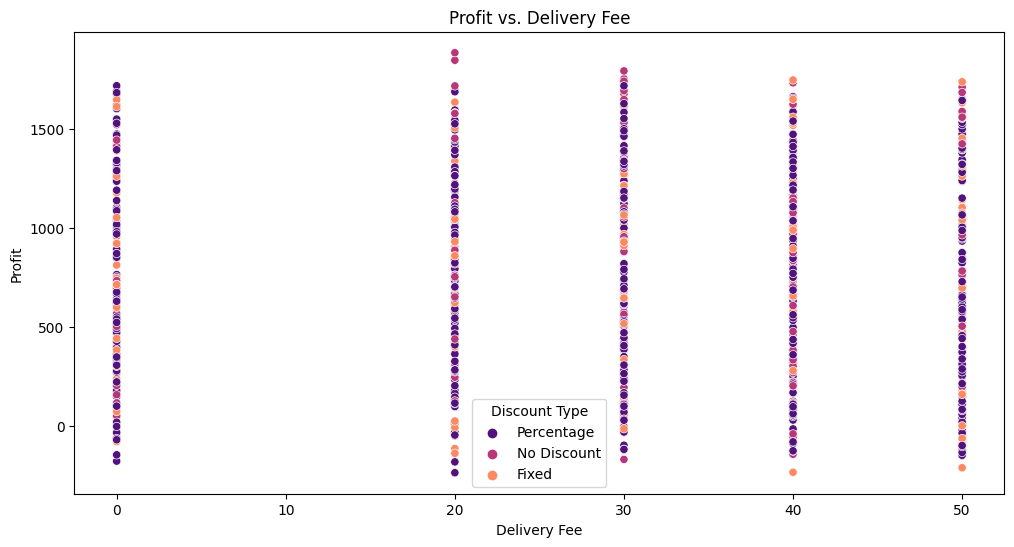

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Delivery Fee', y='Profit', data=df, hue='Discount Type', palette='magma')
plt.title('Profit vs. Delivery Fee')
plt.xlabel('Delivery Fee')
plt.ylabel('Profit')
plt.show()


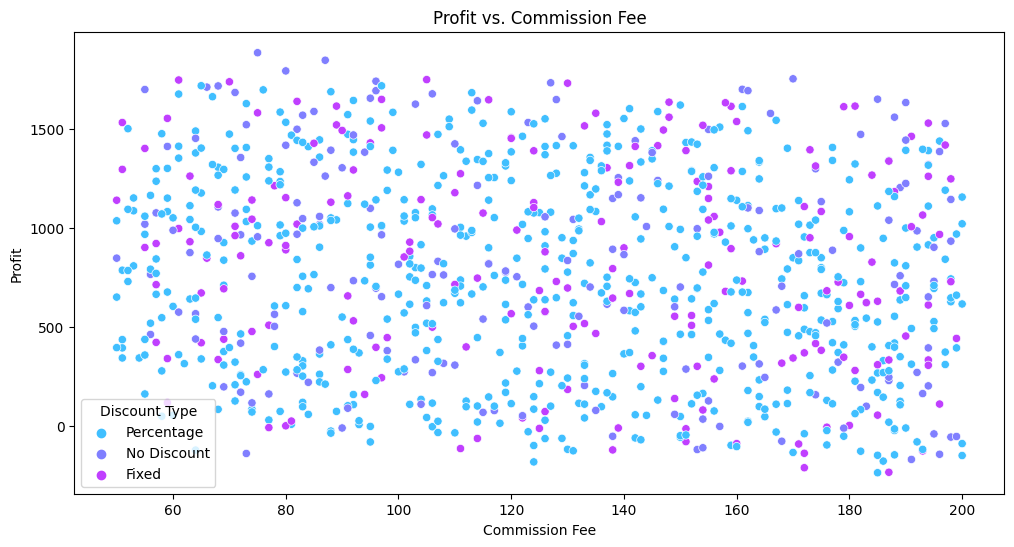

In [24]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Commission Fee', y='Profit', data=df, hue='Discount Type', palette='cool')
plt.title('Profit vs. Commission Fee')
plt.xlabel('Commission Fee')
plt.ylabel('Profit')
plt.show()


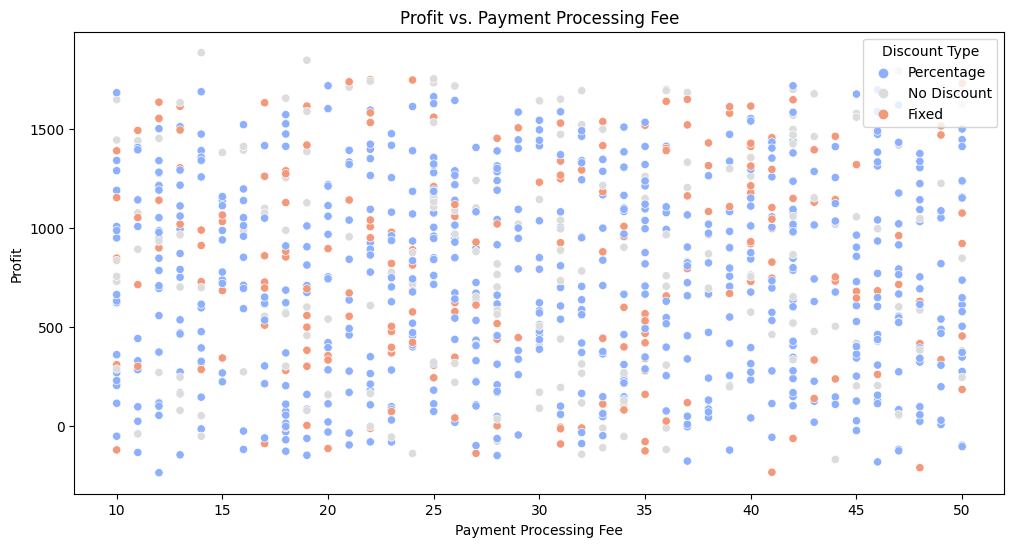

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Payment Processing Fee', y='Profit', data=df, hue='Discount Type', palette='coolwarm')
plt.title('Profit vs. Payment Processing Fee')
plt.xlabel('Payment Processing Fee')
plt.ylabel('Profit')
plt.show()


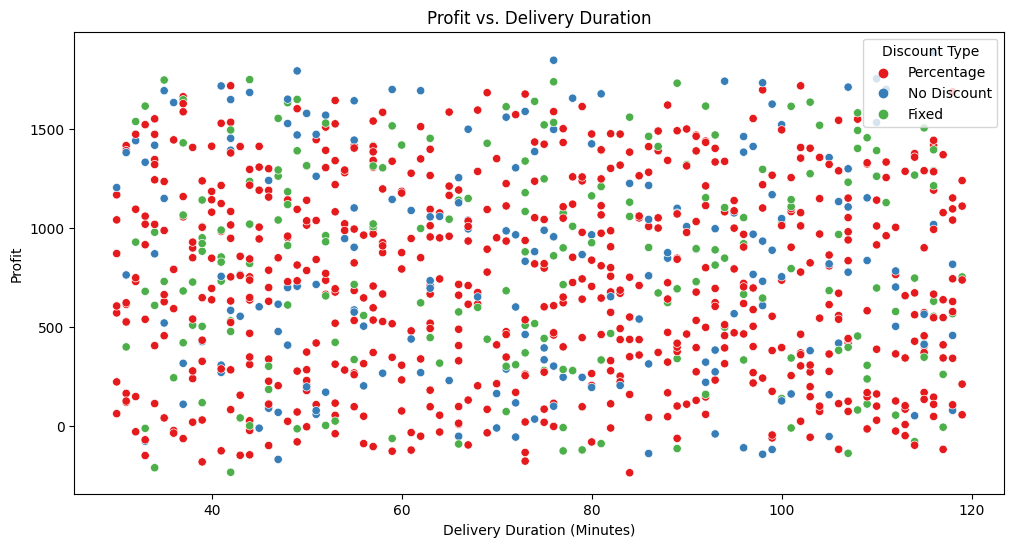

In [26]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Delivery Duration', y='Profit', data=df, hue='Discount Type', palette='Set1')
plt.title('Profit vs. Delivery Duration')
plt.xlabel('Delivery Duration (Minutes)')
plt.ylabel('Profit')
plt.show()


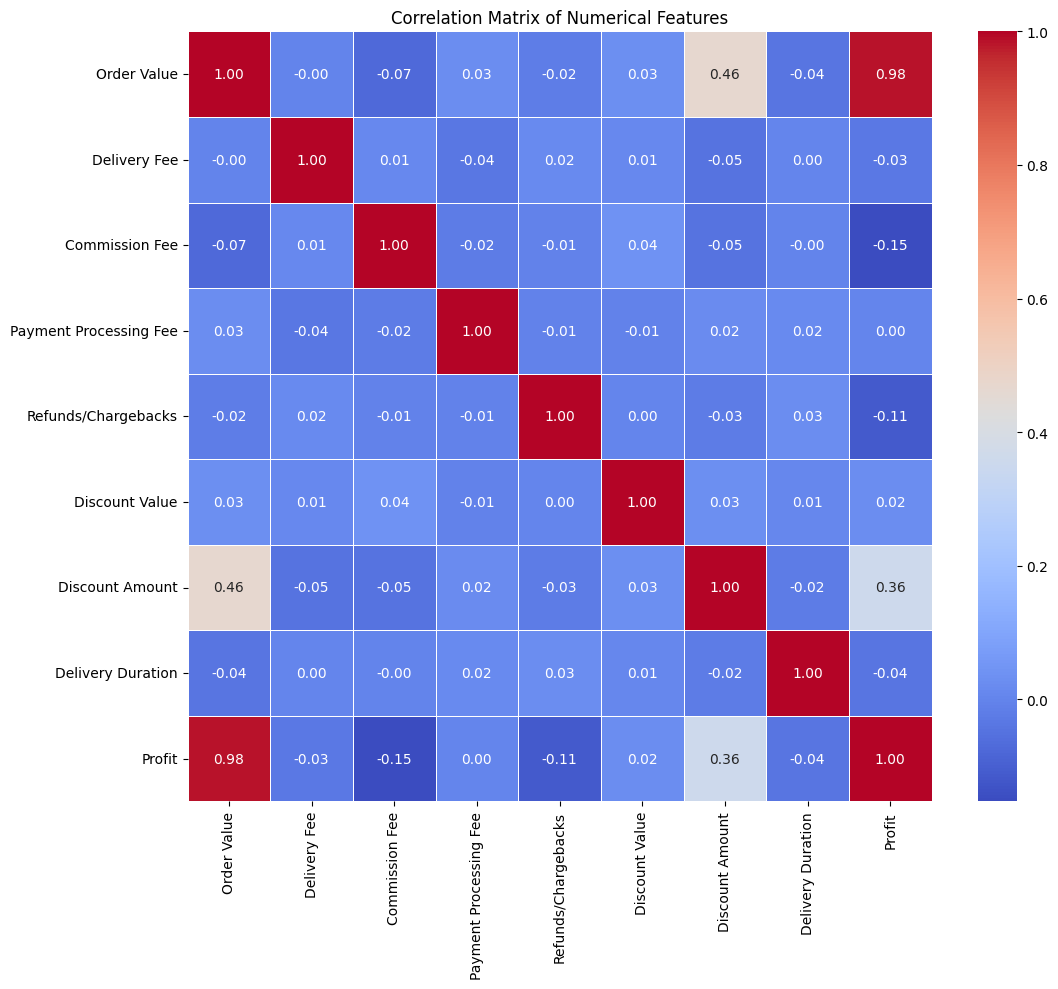

In [27]:
numerical_cols = ['Order Value', 'Delivery Fee', 'Commission Fee', 
                  'Payment Processing Fee', 'Refunds/Chargebacks', 
                  'Discount Value', 'Discount Amount', 'Delivery Duration', 'Profit']


corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


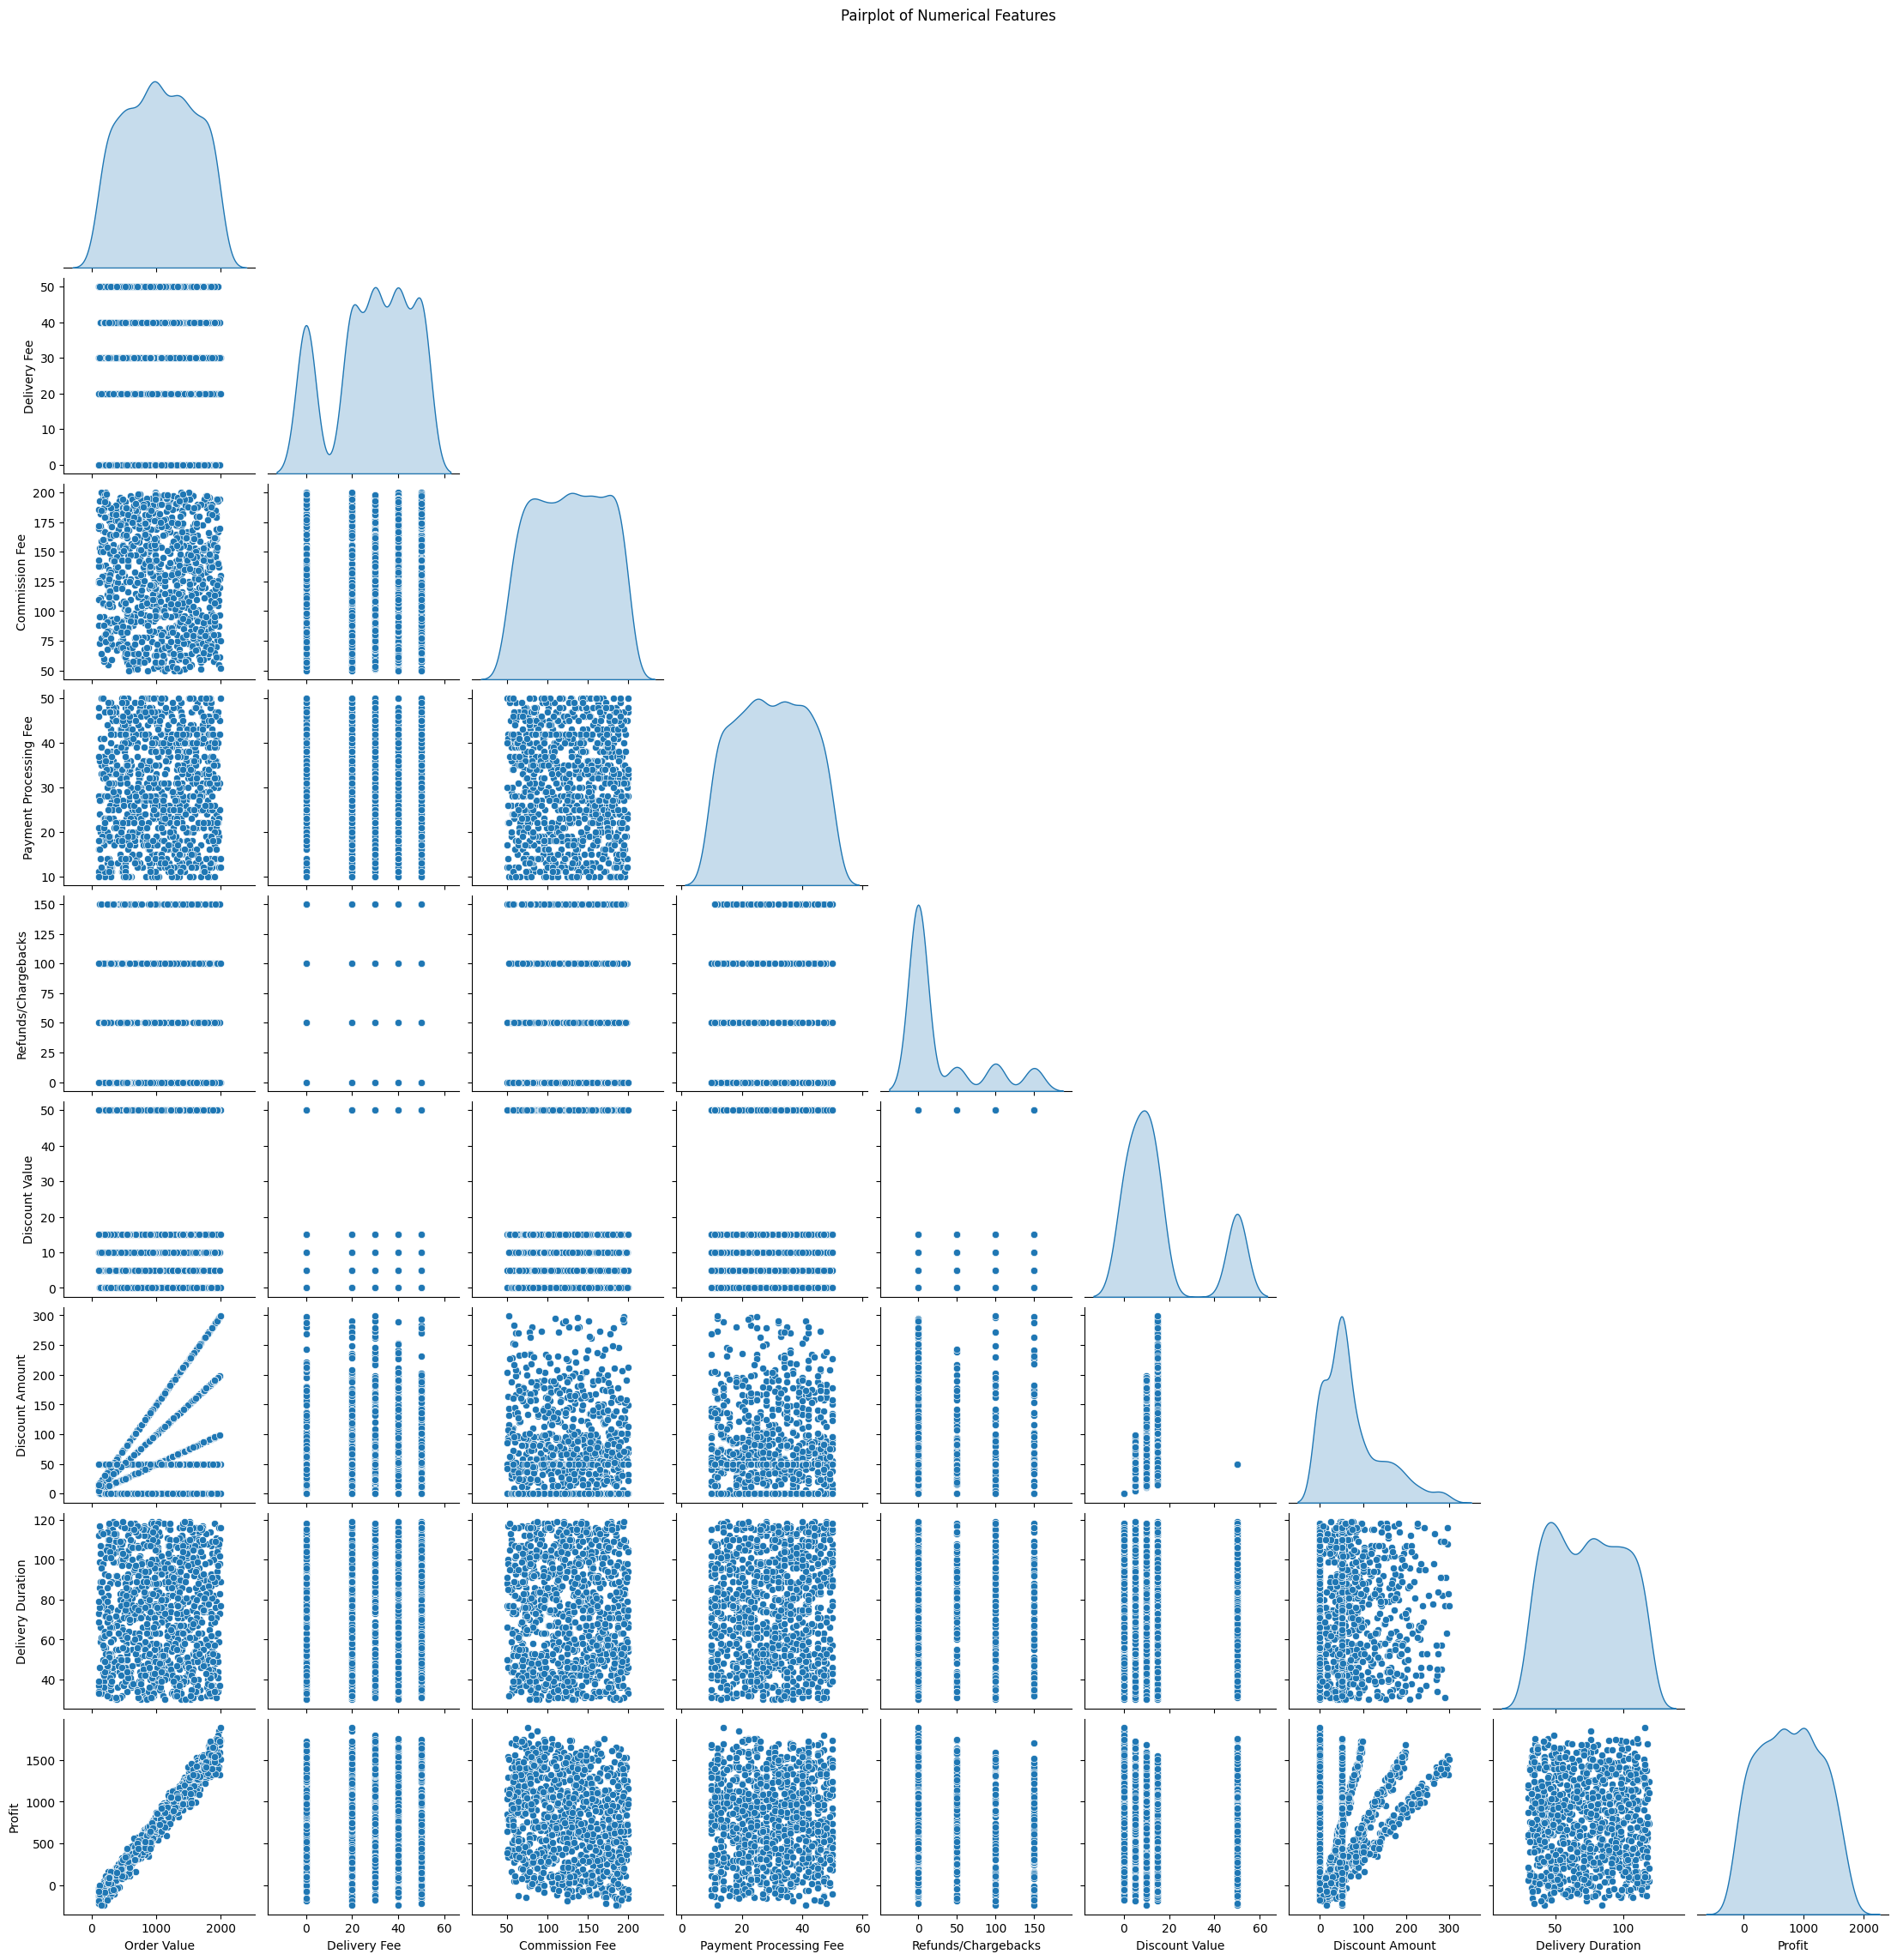

In [28]:
sns.pairplot(df[numerical_cols], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()


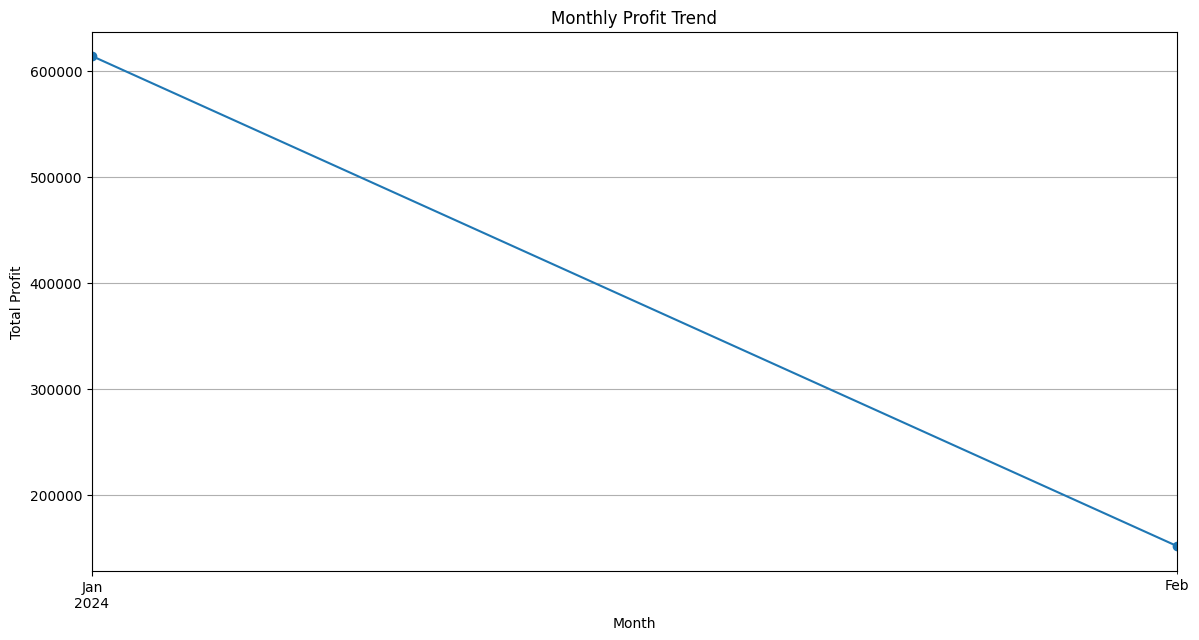

In [29]:
df_ts = df.set_index('Order Date and Time')
monthly_profit = df_ts['Profit'].resample('M').sum() #resample for trend analysis
plt.figure(figsize=(14, 7))
monthly_profit.plot(marker='o', linestyle='-')
plt.title('Monthly Profit Trend')
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.grid(True)
plt.show()


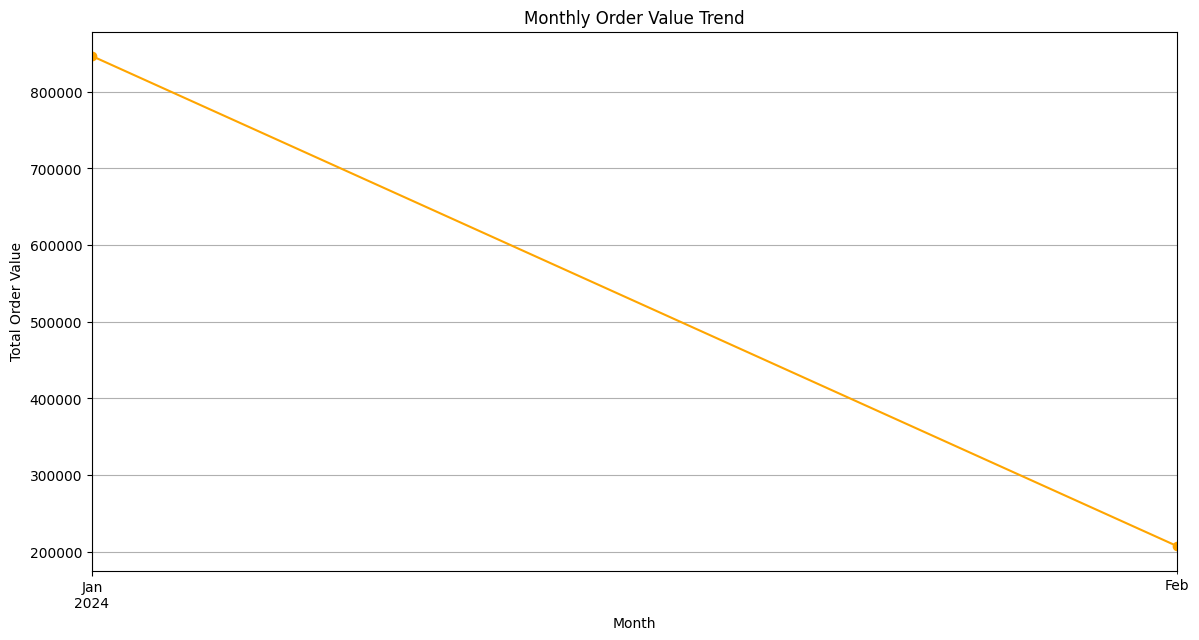

In [30]:
monthly_order_value = df_ts['Order Value'].resample('M').sum()
plt.figure(figsize=(14, 7))
monthly_order_value.plot(marker='o', linestyle='-', color='orange')
plt.title('Monthly Order Value Trend')
plt.xlabel('Month')
plt.ylabel('Total Order Value')
plt.grid(True)
plt.show()


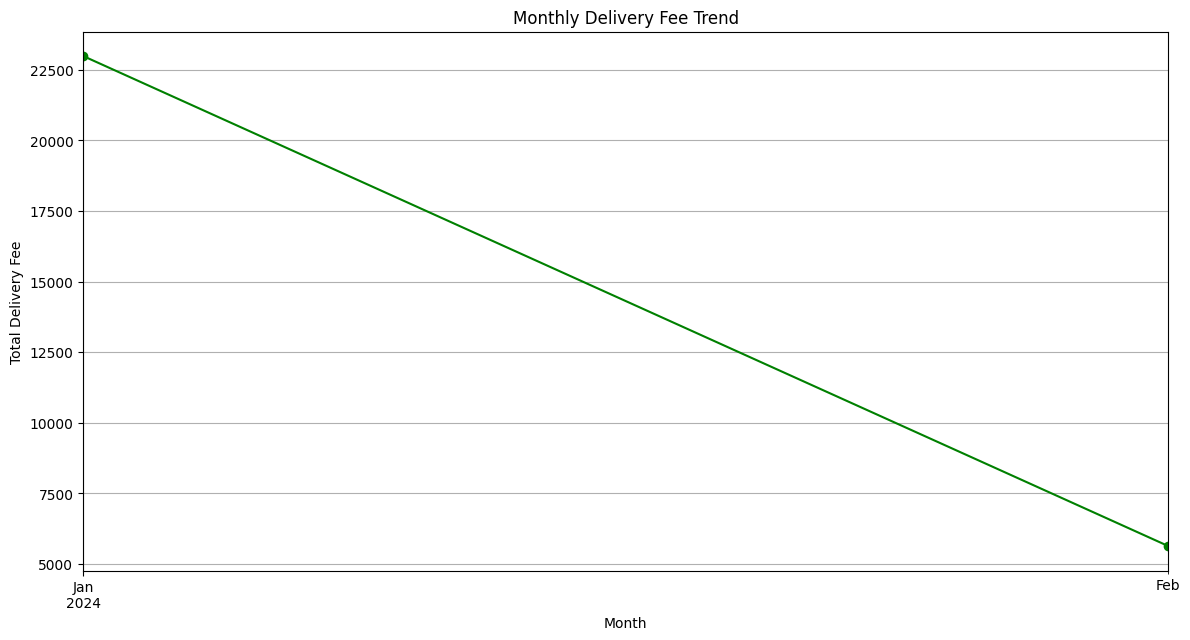

In [31]:
monthly_delivery_fee = df_ts['Delivery Fee'].resample('M').sum()
plt.figure(figsize=(14, 7))
monthly_delivery_fee.plot(marker='o', linestyle='-', color='green')
plt.title('Monthly Delivery Fee Trend')
plt.xlabel('Month')
plt.ylabel('Total Delivery Fee')
plt.grid(True)
plt.show()


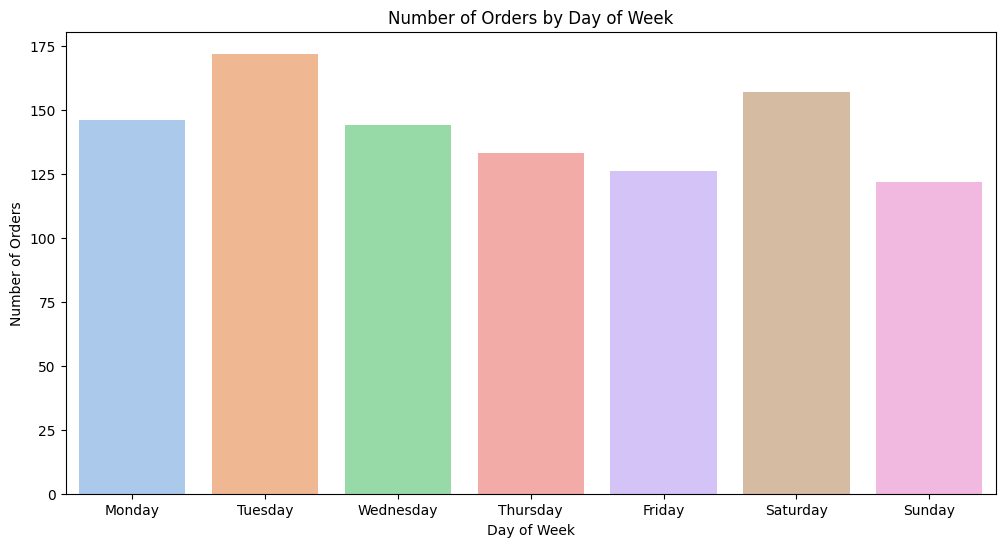

In [32]:
df_ts['Day of Week'] = df_ts.index.day_name()
plt.figure(figsize=(12, 6))
sns.countplot(x='Day of Week', data=df_ts, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='pastel')
plt.title('Number of Orders by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.show()


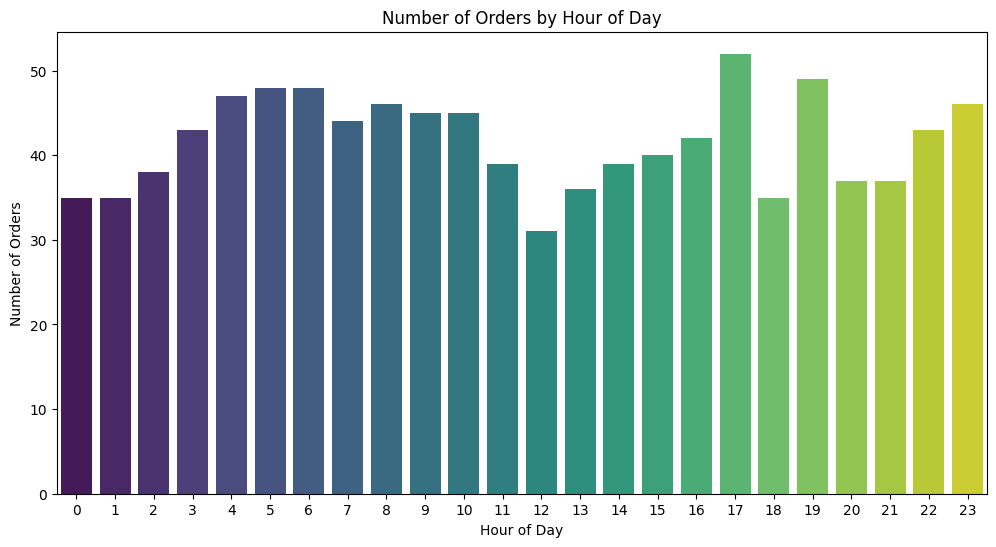

In [33]:
df_ts['Order Hour'] = df_ts.index.hour
plt.figure(figsize=(12, 6))
sns.countplot(x='Order Hour', data=df_ts, palette='viridis')
plt.title('Number of Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.show()


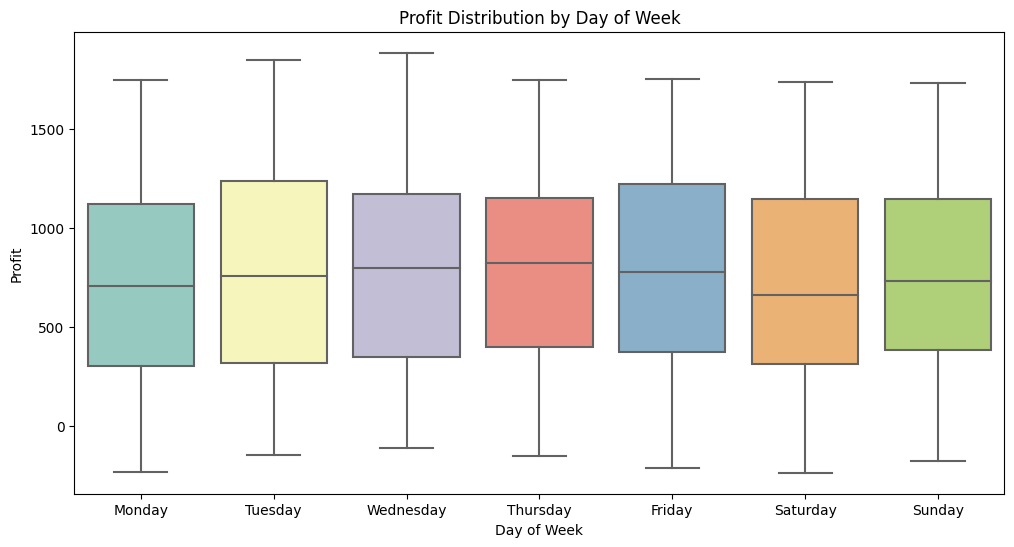

In [34]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Day of Week', y='Profit', data=df_ts, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='Set3')
plt.title('Profit Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Profit')
plt.show()


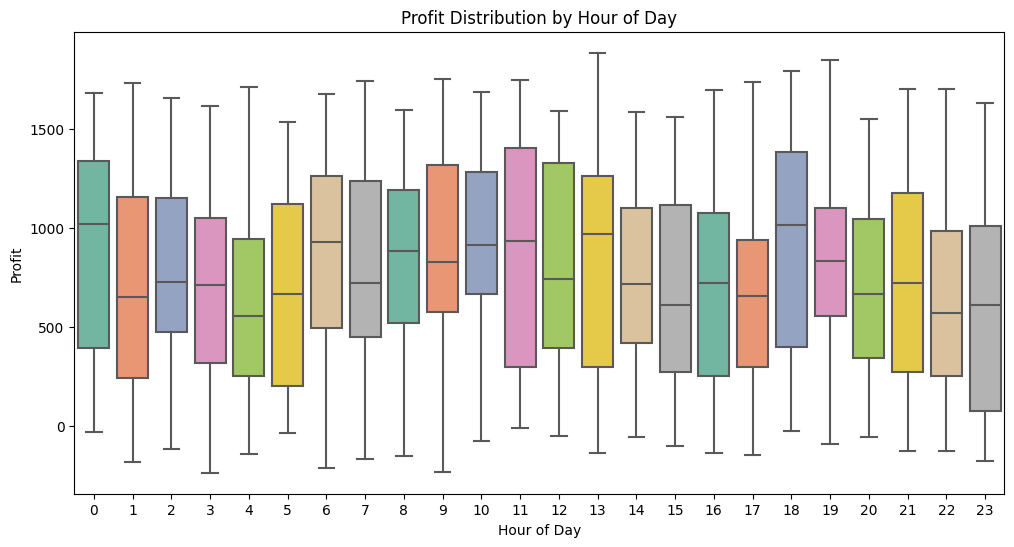

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Order Hour', y='Profit', data=df_ts, palette='Set2')
plt.title('Profit Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Profit')
plt.show()


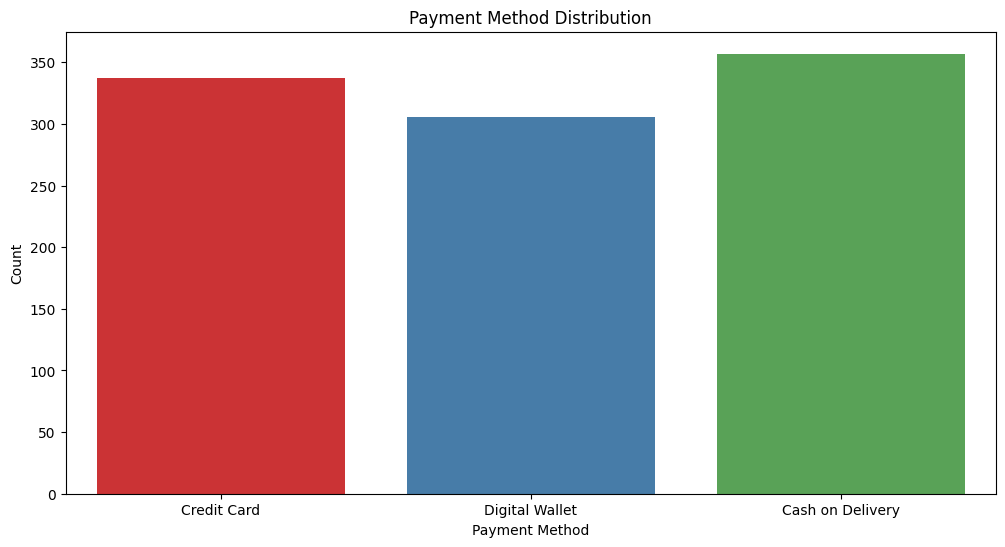

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Payment Method', data=df, palette='Set1')
plt.title('Payment Method Distribution')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.show()


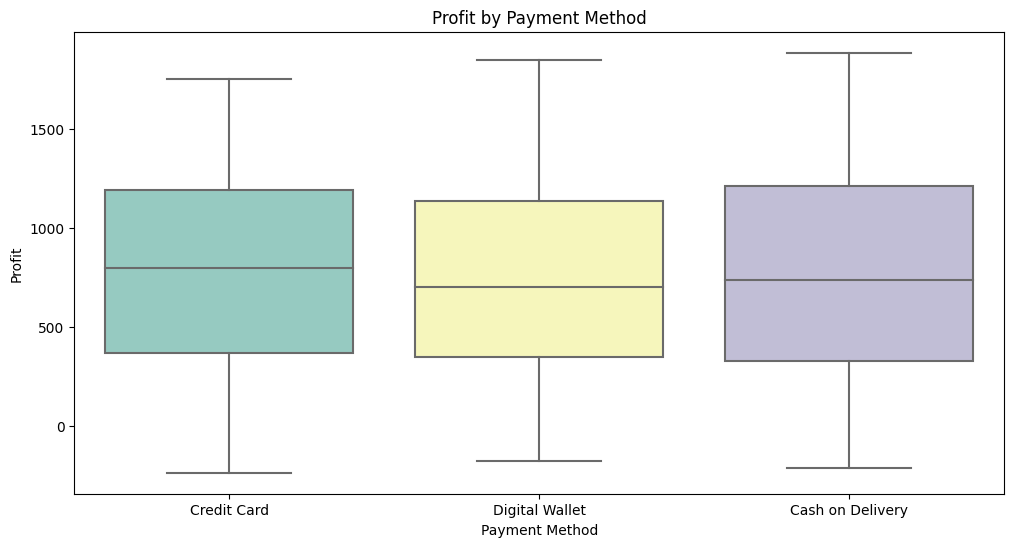

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Payment Method', y='Profit', data=df, palette='Set3')
plt.title('Profit by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Profit')
plt.show()


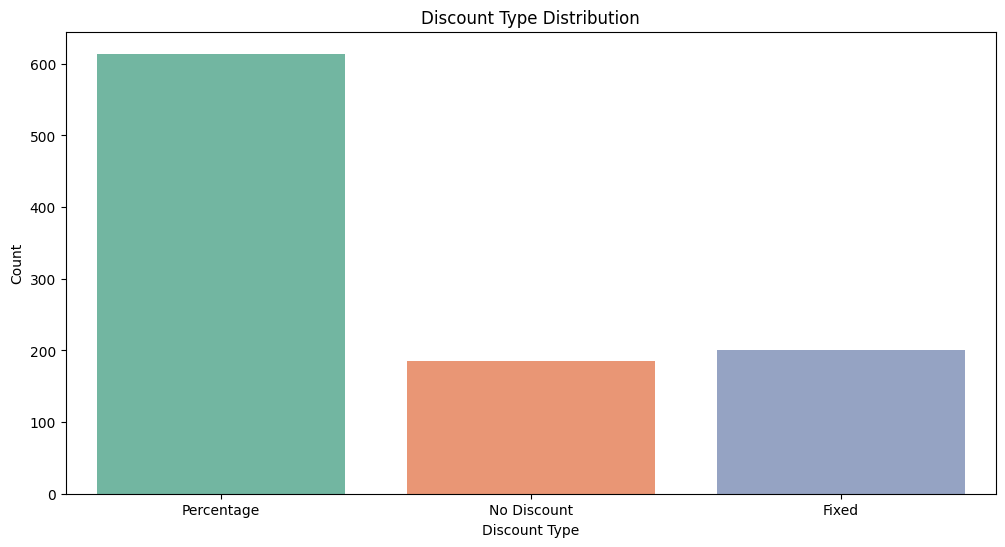

In [38]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Discount Type', data=df, palette='Set2')
plt.title('Discount Type Distribution')
plt.xlabel('Discount Type')
plt.ylabel('Count')
plt.show()


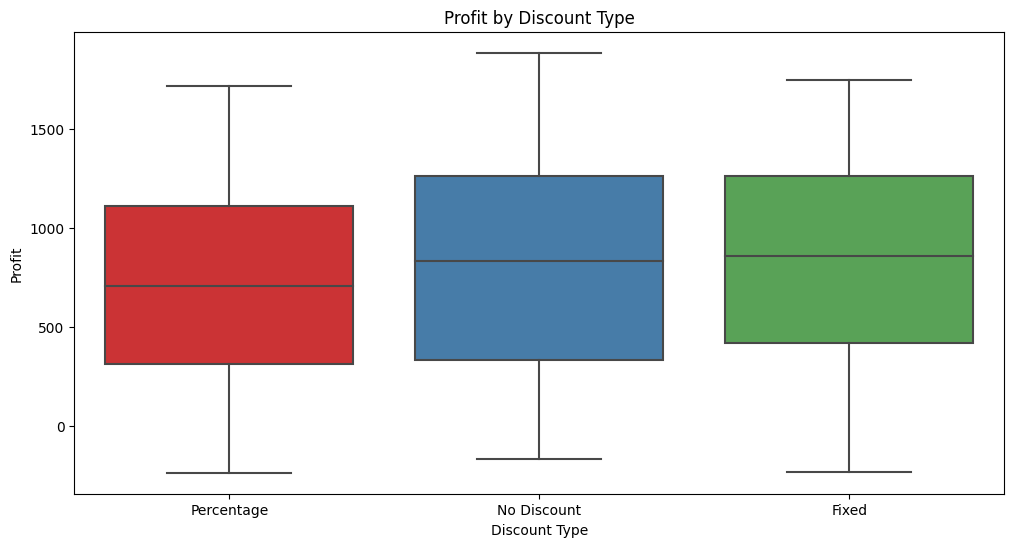

In [39]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Discount Type', y='Profit', data=df, palette='Set1')
plt.title('Profit by Discount Type')
plt.xlabel('Discount Type')
plt.ylabel('Profit')
plt.show()


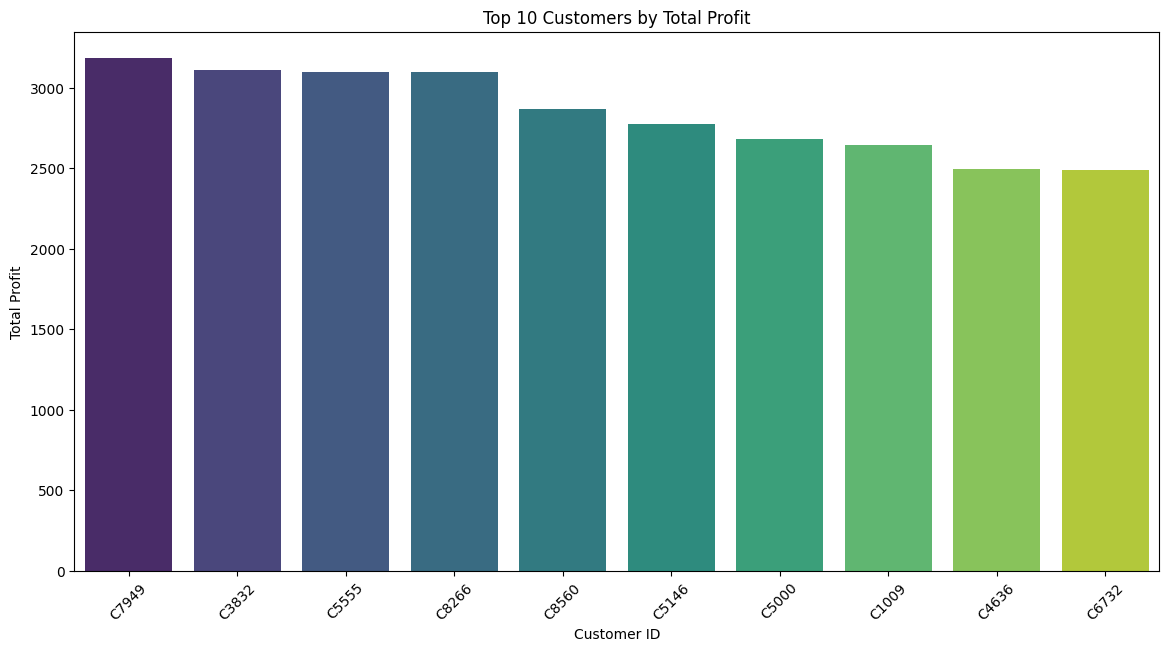

In [40]:
customer_profit = df.groupby('Customer ID')['Profit'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 7))
sns.barplot(x=customer_profit.index, y=customer_profit.values, palette='viridis')
plt.title('Top 10 Customers by Total Profit')
plt.xlabel('Customer ID')
plt.ylabel('Total Profit')
plt.xticks(rotation=45)
plt.show()

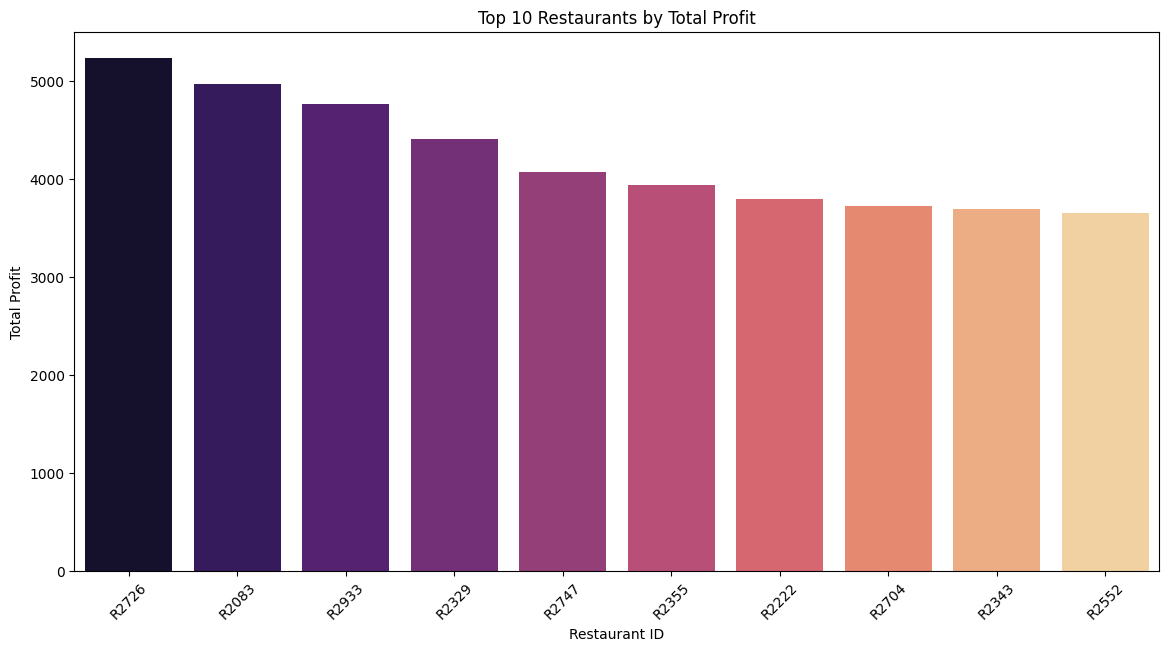

In [41]:
restaurant_profit = df.groupby('Restaurant ID')['Profit'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 7))
sns.barplot(x=restaurant_profit.index, y=restaurant_profit.values, palette='magma')
plt.title('Top 10 Restaurants by Total Profit')
plt.xlabel('Restaurant ID')
plt.ylabel('Total Profit')
plt.xticks(rotation=45)
plt.show()

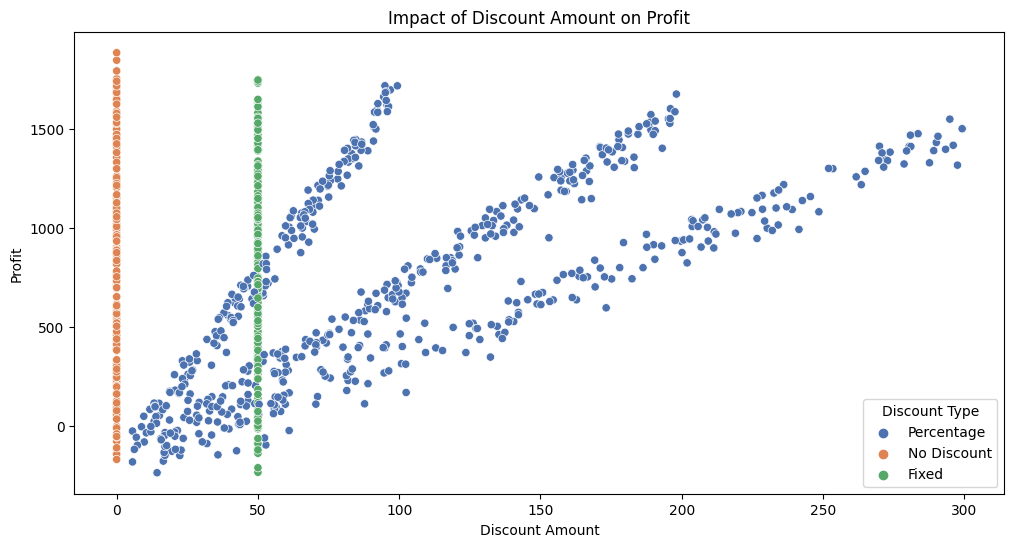

In [42]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Discount Amount', y='Profit', data=df, hue='Discount Type', palette='deep')
plt.title('Impact of Discount Amount on Profit')
plt.xlabel('Discount Amount')
plt.ylabel('Profit')
plt.show()


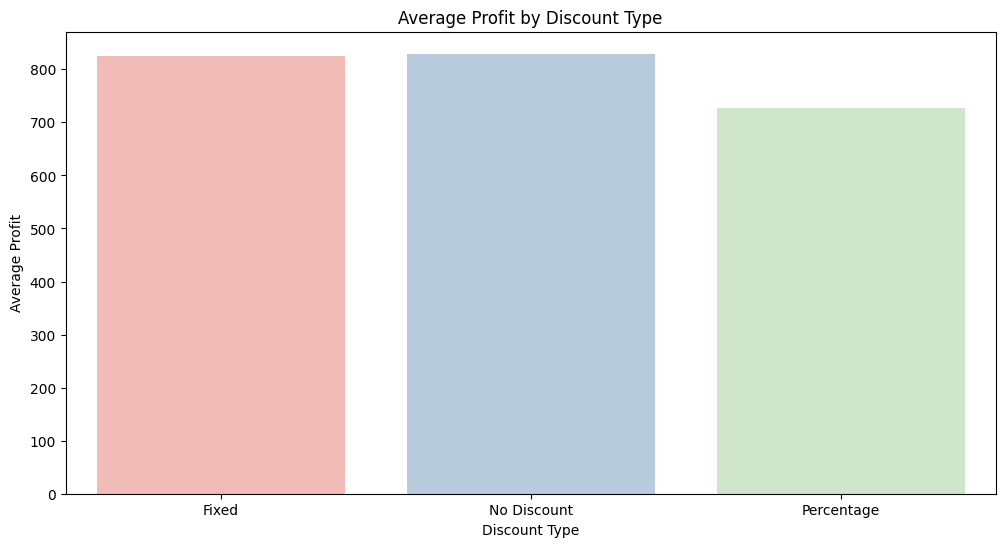

In [43]:
avg_profit_discount = df.groupby('Discount Type')['Profit'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Discount Type', y='Profit', data=avg_profit_discount, palette='Pastel1')
plt.title('Average Profit by Discount Type')
plt.xlabel('Discount Type')
plt.ylabel('Average Profit')
plt.show()


In [44]:
total_refunds = df['Refunds/Chargebacks'].sum()

print(f"Total Refunds/Chargebacks: {total_refunds}")


Total Refunds/Chargebacks: 28300


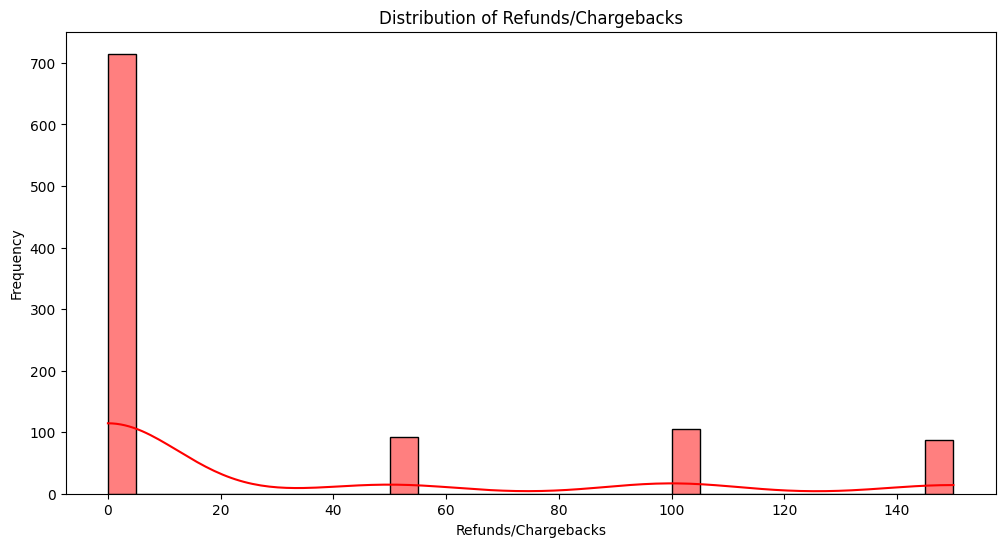

In [45]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Refunds/Chargebacks'], bins=30, kde=True, color='red')
plt.title('Distribution of Refunds/Chargebacks')
plt.xlabel('Refunds/Chargebacks')
plt.ylabel('Frequency')
plt.show()


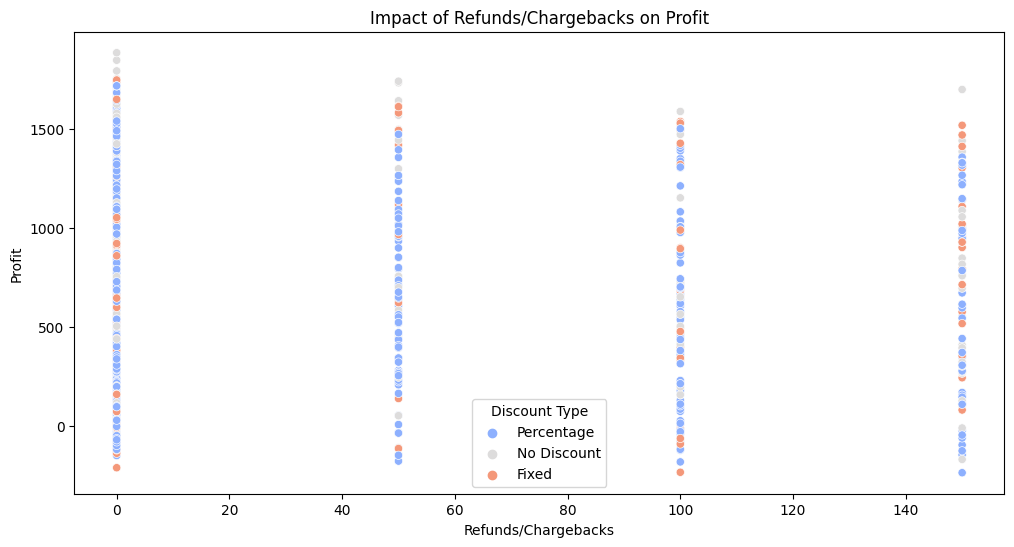

In [46]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Refunds/Chargebacks', y='Profit', data=df, hue='Discount Type', palette='coolwarm')
plt.title('Impact of Refunds/Chargebacks on Profit')
plt.xlabel('Refunds/Chargebacks')
plt.ylabel('Profit')
plt.show()


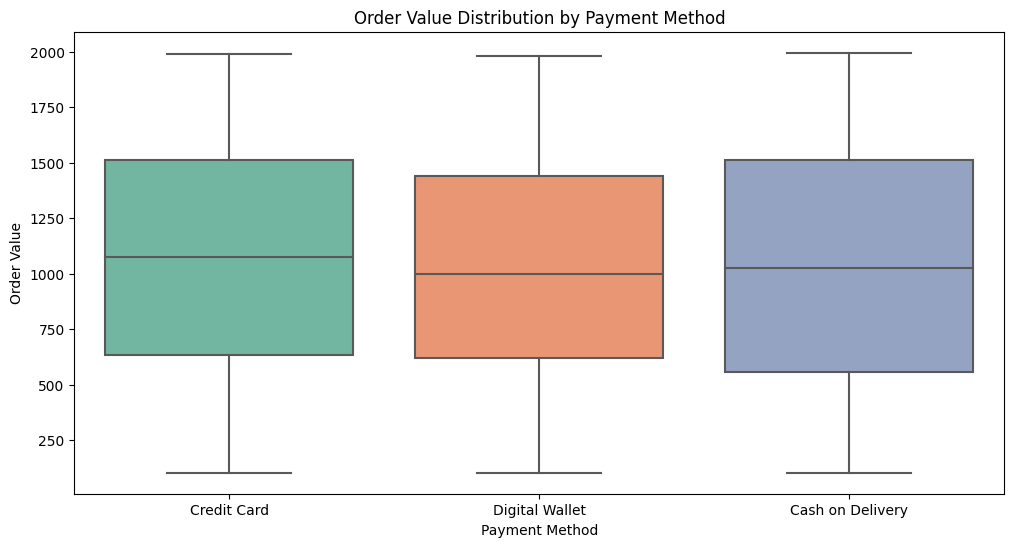

In [47]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Payment Method', y='Order Value', data=df, palette='Set2')
plt.title('Order Value Distribution by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Order Value')
plt.show()


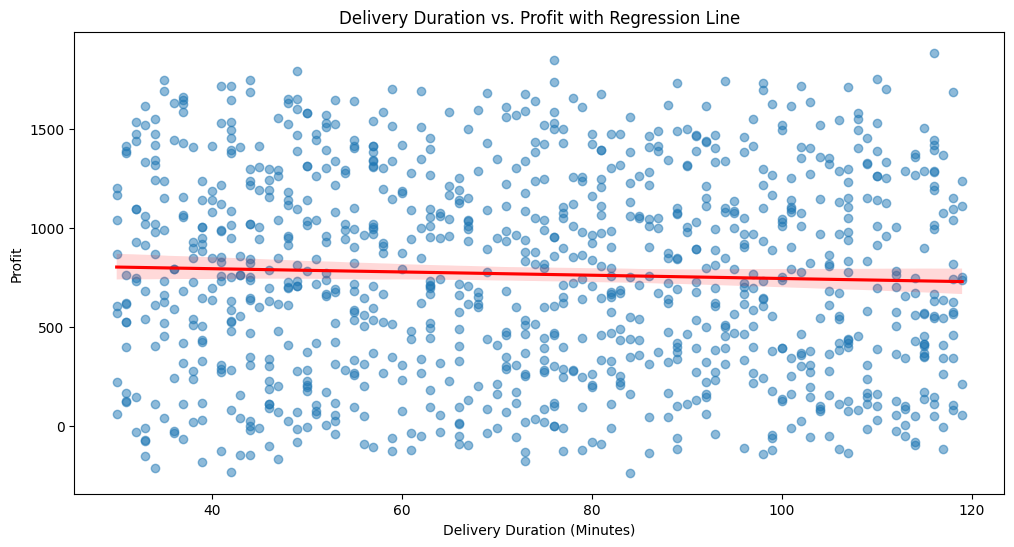

In [48]:
plt.figure(figsize=(12, 6))
sns.regplot(x='Delivery Duration', y='Profit', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Delivery Duration vs. Profit with Regression Line')
plt.xlabel('Delivery Duration (Minutes)')
plt.ylabel('Profit')
plt.show()


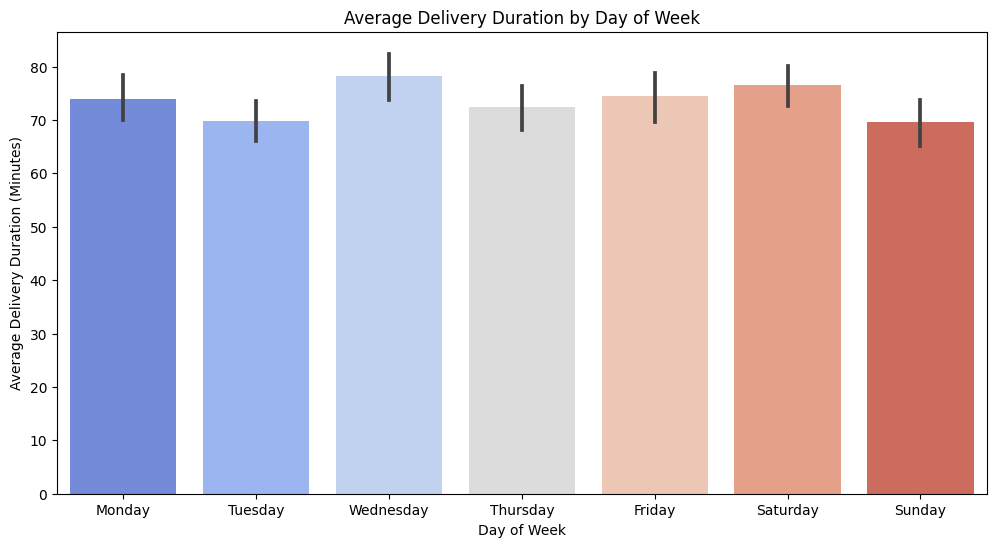

In [49]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Day of Week', y='Delivery Duration', data=df_ts, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='coolwarm')
plt.title('Average Delivery Duration by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Delivery Duration (Minutes)')
plt.show()


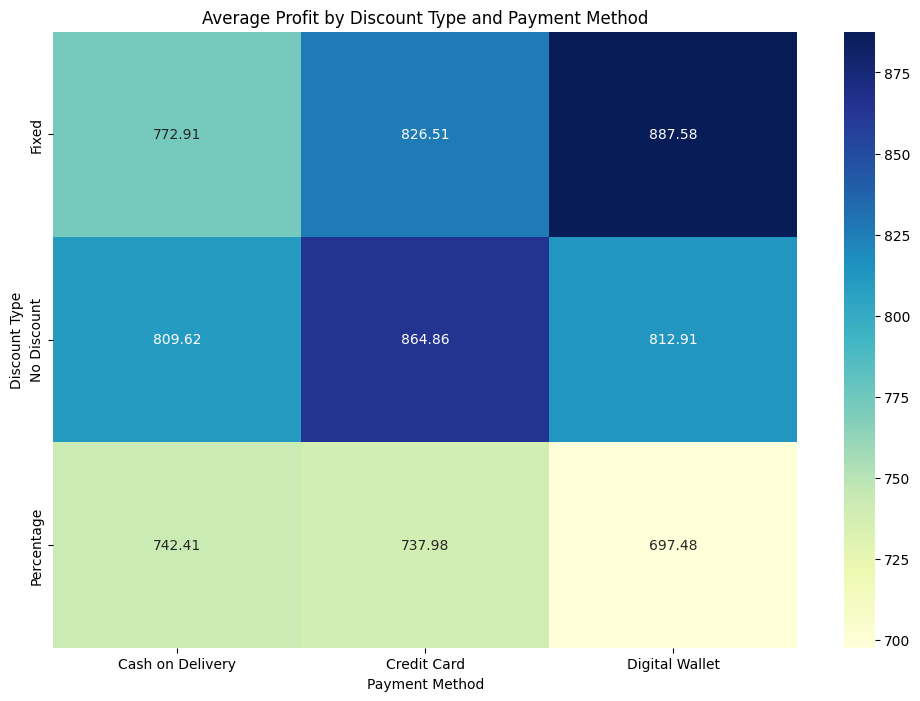

In [50]:
profit_heatmap = df.pivot_table(values='Profit', index='Discount Type', columns='Payment Method', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(profit_heatmap, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Average Profit by Discount Type and Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Discount Type')
plt.show()


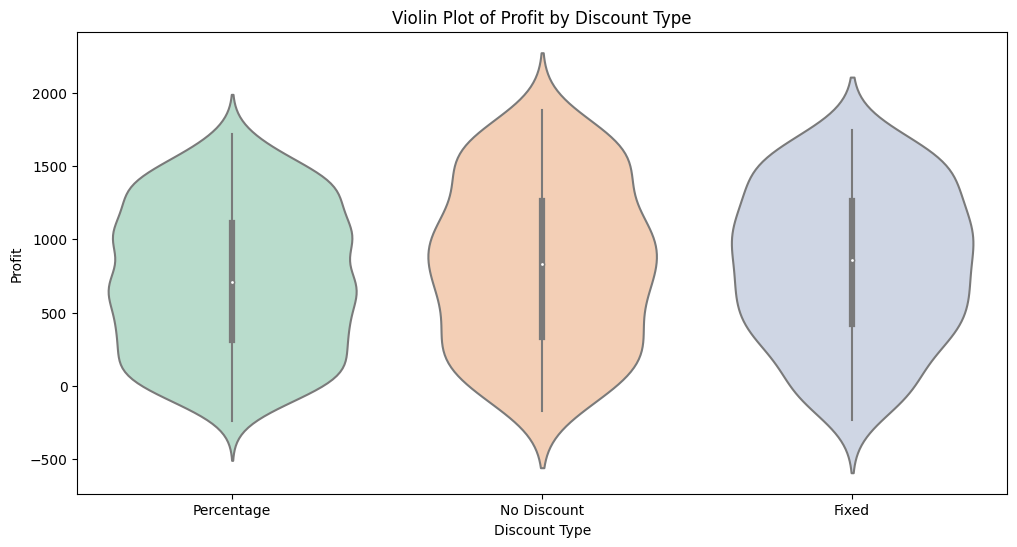

In [51]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Discount Type', y='Profit', data=df, palette='Pastel2')
plt.title('Violin Plot of Profit by Discount Type')
plt.xlabel('Discount Type')
plt.ylabel('Profit')
plt.show()


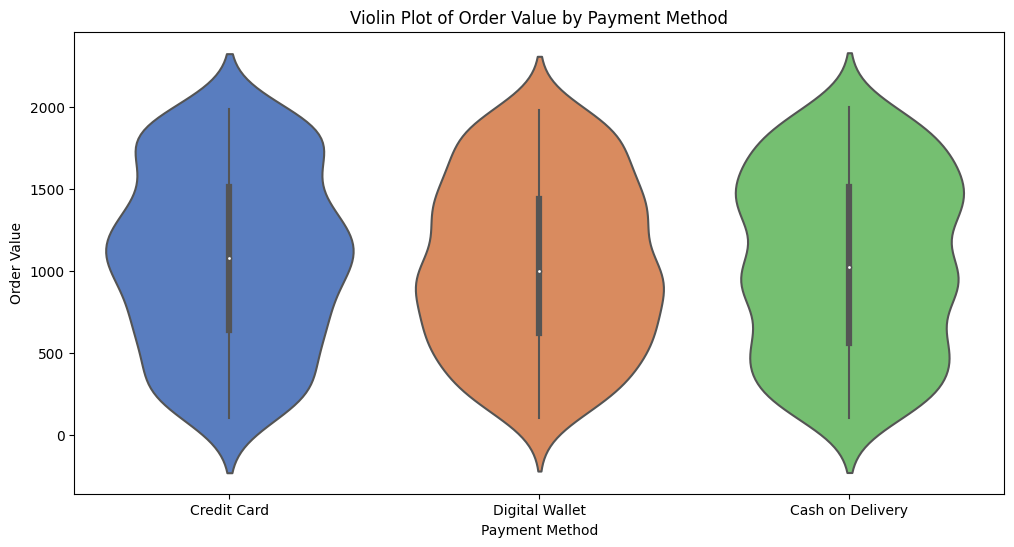

In [52]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Payment Method', y='Order Value', data=df, palette='muted')
plt.title('Violin Plot of Order Value by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Order Value')
plt.show()


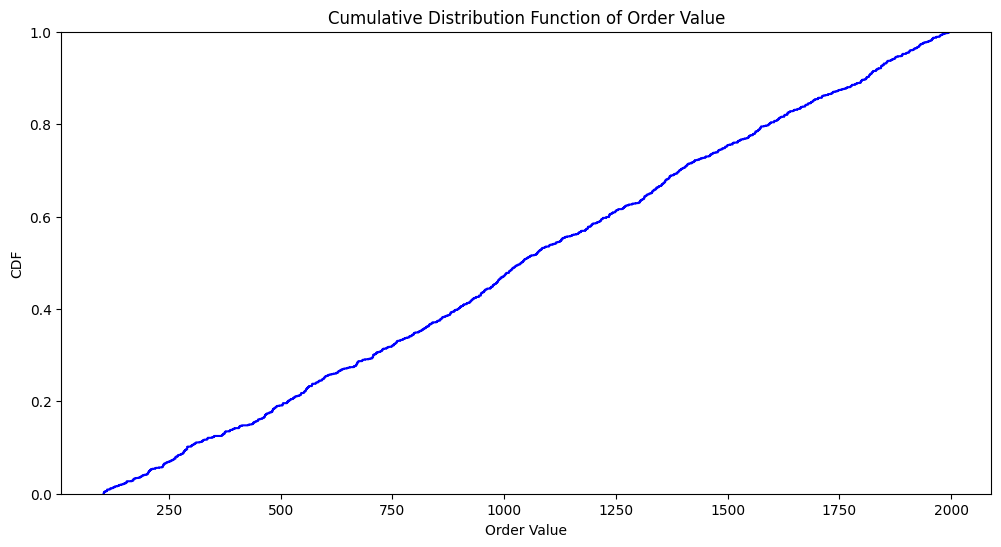

In [53]:
plt.figure(figsize=(12, 6))
sns.ecdfplot(df['Order Value'], color='blue')
plt.title('Cumulative Distribution Function of Order Value')
plt.xlabel('Order Value')
plt.ylabel('CDF')
plt.show()


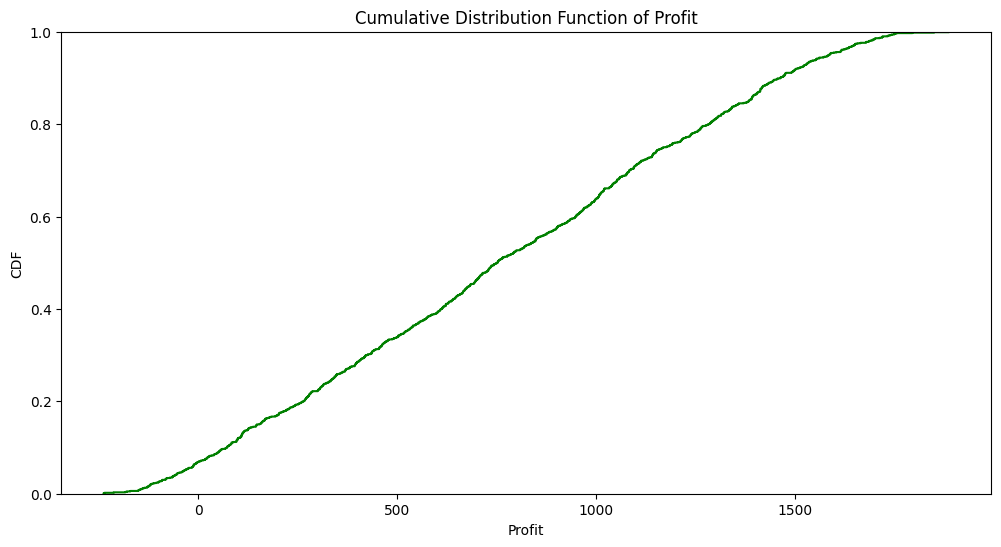

In [54]:
plt.figure(figsize=(12, 6))
sns.ecdfplot(df['Profit'], color='green')
plt.title('Cumulative Distribution Function of Profit')
plt.xlabel('Profit')
plt.ylabel('CDF')
plt.show()


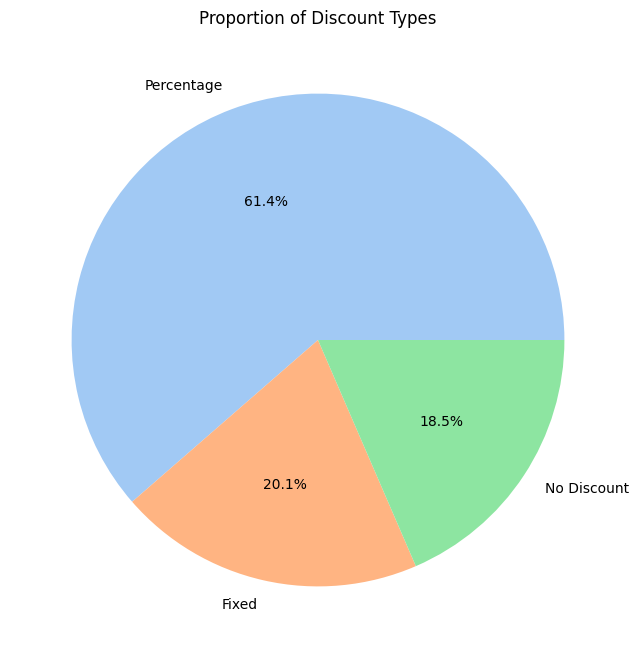

In [55]:
discount_counts = df['Discount Type'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(discount_counts, labels=discount_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Proportion of Discount Types')
plt.show()


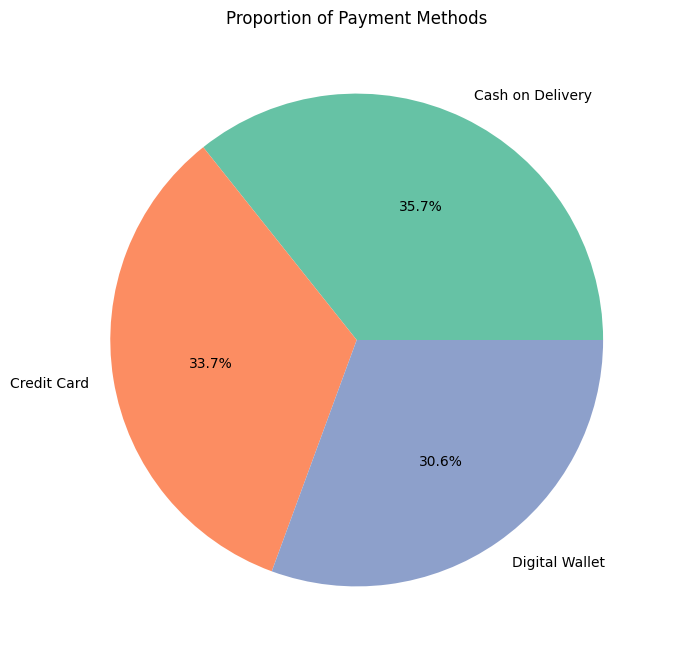

In [56]:
payment_counts = df['Payment Method'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Proportion of Payment Methods')
plt.show()


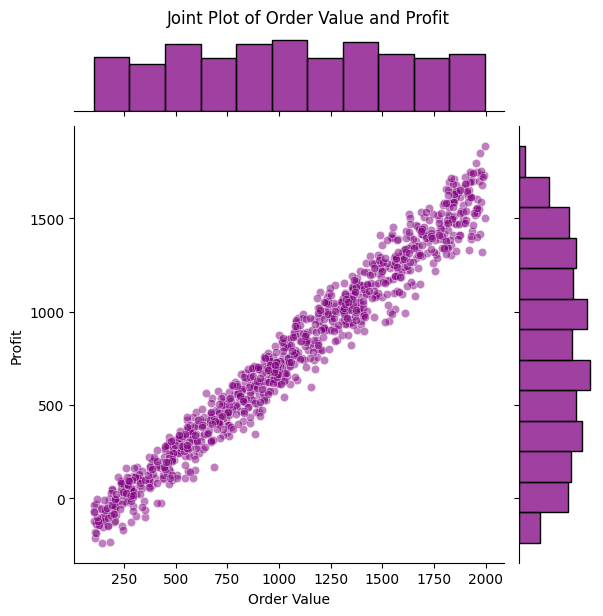

In [57]:
sns.jointplot(x='Order Value', y='Profit', data=df, kind='scatter', color='purple', alpha=0.5)
plt.suptitle('Joint Plot of Order Value and Profit', y=1.02)
plt.show()


In [58]:
df['Order Date and Time'] = pd.to_datetime(df['Order Date and Time'])
df['Delivery Date and Time'] = pd.to_datetime(df['Delivery Date and Time'])
df['Order Hour'] = df['Order Date and Time'].dt.hour
df['Order Day'] = df['Order Date and Time'].dt.dayofweek
df['Delivery Duration'] = (df['Delivery Date and Time'] - df['Order Date and Time']).dt.total_seconds() / 60.0

In [59]:
print(df.columns)

Index(['Order ID', 'Customer ID', 'Restaurant ID', 'Order Date and Time',
       'Delivery Date and Time', 'Order Value', 'Delivery Fee',
       'Payment Method', 'Discounts and Offers', 'Commission Fee',
       'Payment Processing Fee', 'Refunds/Chargebacks', 'Delivery Duration',
       'Discount Value', 'Discount Type', 'Discount Amount', 'Profit',
       'Order Hour', 'Order Day'],
      dtype='object')


# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#FC8019; overflow:hidden"><b>Model</b></div>

In [60]:
df['Order Date and Time'] = pd.to_datetime(df['Order Date and Time'])
df['Delivery Date and Time'] = pd.to_datetime(df['Delivery Date and Time'])
df['Order Hour'] = df['Order Date and Time'].dt.hour
df['Order Day'] = df['Order Date and Time'].dt.dayofweek
df['Discounts and Offers'].fillna('No Discount', inplace=True)
df['Discount Type'] = df['Discounts and Offers'].apply(lambda x: 'Percentage' if '%' in str(x) else 'Fixed')
df['Discount Amount'] = df['Discounts and Offers'].str.extract(r'(\d+)', expand=False).astype(float).fillna(0)
df['Discount Value'] = np.where(df['Discount Type'] == 'Percentage', df['Order Value'] * (df['Discount Amount'] / 100), df['Discount Amount'])
df['Delivery Duration'] = (df['Delivery Date and Time'] - df['Order Date and Time']).dt.total_seconds() / 60
df['Profit'] = df['Order Value'] - (df['Delivery Fee'] + df['Commission Fee'] + df['Payment Processing Fee'] + df['Refunds/Chargebacks'])
df.drop(['Order ID', 'Customer ID', 'Restaurant ID', 'Order Date and Time', 'Delivery Date and Time', 'Discounts and Offers'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Payment Method', 'Discount Type'], drop_first=True)

In [61]:
numerical_features = [
    'Order Value', 'Delivery Fee', 'Commission Fee',
    'Payment Processing Fee', 'Refunds/Chargebacks',
    'Delivery Duration', 'Discount Value', 'Discount Amount',
    'Order Hour', 'Order Day'
]


scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

X = df.drop('Profit', axis=1)
y = df['Profit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(
    n_estimators=100,  
    random_state=42,
    n_jobs=-1  
)

rf_model.fit(X_train, y_train)




RandomForestRegressor(n_jobs=-1, random_state=42)

In [62]:
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest Regressor Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Random Forest Regressor Performance:
Mean Squared Error (MSE): 1312.45
Root Mean Squared Error (RMSE): 36.23
R-squared (R²): 0.99


In [63]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse = -cross_val_score(rf_model, X, y, scoring='neg_mean_squared_error', cv=kf)
cv_rmse = np.sqrt(cv_mse)
cv_r2 = cross_val_score(rf_model, X, y, scoring='r2', cv=kf)
print(f"Cross-Validation MSE: {cv_mse}")
print(f"Cross-Validation RMSE: {cv_rmse}")
print(f"Cross-Validation R²: {cv_r2}")
print(f"Average CV R²: {cv_r2.mean()}")


Cross-Validation MSE: [1273.294443  1581.6967125 1353.033713  1260.2884675 1437.7333465]
Cross-Validation RMSE: [35.68325158 39.77055082 36.78360658 35.50054179 37.91745438]
Cross-Validation R²: [0.99490857 0.99483224 0.99525112 0.9956903  0.9954032 ]
Average CV R²: 0.9952170856616245


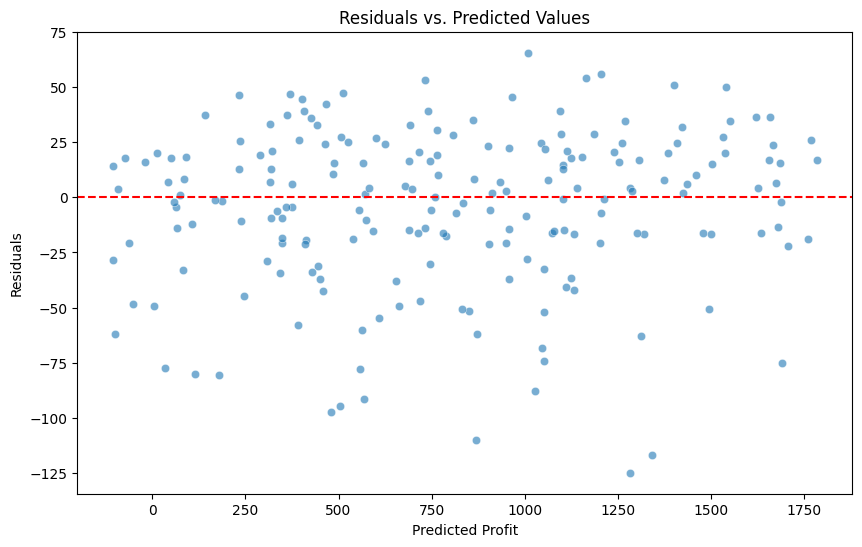

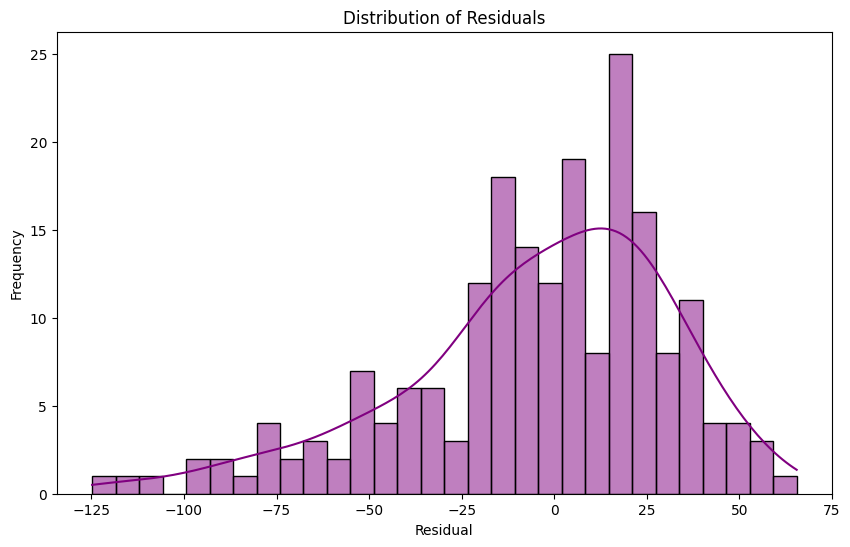

In [64]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Profit')
plt.ylabel('Residuals')
plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

<div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#FC8019; overflow:hidden">
  <b></b><br>
  If you found this notebook helpful, please consider upvoting it! Thank you!
</div>